## Check the accuracy of the sentiment prediction by utilizing moving average strategy

In [1]:
import numpy as np
import pandas as pd
from firebase_credentials import config
import pyrebase
import yfinance as yf
import company_list
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Download the sentiment prediction files from Firebase
firebase = pyrebase.initialize_app(config)
storage = firebase.storage()

path_on_cloud1 = "Predictions/2022_Feb_Predictions/sentiment_prediction/1_spositive.csv"
path_on_cloud2 = "Predictions/2022_Feb_Predictions/sentiment_prediction/2_positive.csv"
path_on_cloud3 = "Predictions/2022_Feb_Predictions/sentiment_prediction/3_wpositive.csv"
path_on_cloud4 = "Predictions/2022_Feb_Predictions/sentiment_prediction/4_neutral.csv"
path_on_cloud5 = "Predictions/2022_Feb_Predictions/sentiment_prediction/5_wnegative.csv"
path_on_cloud6 = "Predictions/2022_Feb_Predictions/sentiment_prediction/6_negative.csv"
path_on_cloud7 = "Predictions/2022_Feb_Predictions/sentiment_prediction/7_snegative.csv"

storage.child(path_on_cloud1).download("","predicted_sentiment_values/spositive.csv")
storage.child(path_on_cloud2).download("","predicted_sentiment_values/positive.csv")
storage.child(path_on_cloud3).download("","predicted_sentiment_values/wpositive.csv")
storage.child(path_on_cloud4).download("","predicted_sentiment_values/neutral.csv")
storage.child(path_on_cloud5).download("","predicted_sentiment_values/wnegative.csv")
storage.child(path_on_cloud6).download("","predicted_sentiment_values/negative.csv")
storage.child(path_on_cloud7).download("","predicted_sentiment_values/snegative.csv")

In [3]:
# read .csv files
df1 = pd.read_csv("predicted_sentiment_values/spositive.csv")
df2 = pd.read_csv("predicted_sentiment_values/positive.csv")
df3 = pd.read_csv("predicted_sentiment_values/wpositive.csv")
df4 = pd.read_csv("predicted_sentiment_values/neutral.csv")
df5 = pd.read_csv("predicted_sentiment_values/wnegative.csv")
df6 = pd.read_csv("predicted_sentiment_values/negative.csv")
df7 = pd.read_csv("predicted_sentiment_values/snegative.csv")

# convert dataframe into a list
df1 = df1.values.tolist()
df2 = df2.values.tolist()
df3 = df3.values.tolist()
df4 = df4.values.tolist()
df5 = df5.values.tolist()
df6 = df6.values.tolist()
df7 = df7.values.tolist()

In [4]:
# convert 2D list into 1D list
spositive_list = list()
if(len(df1) != 0):
    for i in df1:
        for j in i:
            spositive_list.append(j)
            
positive_list = list()
if(len(df2) != 0):
    for i in df2:
        for j in i:
            positive_list.append(j)
            
wpositive_list = list()
if(len(df3) != 0):
    for i in df3:
        for j in i:
            wpositive_list.append(j)
            
neutral_list = list()
if(len(df4) != 0):
    for i in df4:
        for j in i:
            neutral_list.append(j)
            
wnegative_list = list()
if(len(df5) != 0):
    for i in df5:
        for j in i:
            wnegative_list.append(j)
            
negative_list = list()
if(len(df6) != 0):
    for i in df6:
        for j in i:
            negative_list.append(j)
            
snegative_list = list()
if(len(df7) != 0):
    for i in df7:
        for j in i:
            snegative_list.append(j)

### Download the monthly stock info in 2022 Jan

In [5]:
def moving_avarage_analysis(prediction_list, level):
    if(len(prediction_list) != 0):
        for i in prediction_list:
            # Download the monthly stock info in 2022 Feb
            stock_label = company_list.companies[i]
            df = yf.download(stock_label, start='2022-02-01', end='2022-02-28')
            
            # obtain the value of EMA
            ShortEMA, MiddleEMA, LongEMA = get_EMA(df)
            
            # add the exponential moving average to the data set
            df['Short'] = ShortEMA
            df['Middle'] = MiddleEMA
            df['Long'] = LongEMA
            
            strat = buy_sell_function(df)
            df['Buy'] = strat[0]
            df['Sell'] = strat[1]
            
            plot_graph(df,ShortEMA, MiddleEMA, LongEMA, i, level)

In [6]:
# calculate the three moving averages
# short/fast exponential moving average
# Middle exponential moving average
# long/slow exponential moving average
def get_EMA(df):
    ShortEMA = df.Close.ewm(span=5, adjust = False).mean()
    MiddleEMA = df.Close.ewm(span = 21, adjust = False).mean()
    LongEMA = df.Close.ewm(span=63, adjust = False).mean()
    return(ShortEMA, MiddleEMA, LongEMA)

In [7]:
# create the function to buy and sell the stock
def buy_sell_function(data):
    buy_list = list()
    sell_list = list()
    flag_long = 0
    flag_short = 0
    
    for i in range(0, len(data)):
        if(data['Middle'][i] < data['Long'][i]
            and data['Short'][i] < data['Middle'][i]
            and flag_long == 0
            and flag_short == 0):
            buy_list.append(data['Close'][i])
            sell_list.append(np.nan)
            flag_short = 1
        elif(flag_short == 1 and data['Short'][i] > data['Middle'][i]):
            sell_list.append(data['Close'][i])
            buy_list.append(np.nan)
            flag_short == 0
        elif(data['Middle'][i] > data['Long'][i]
            and data['Short'][i] > data['Middle'][i]
            and flag_long == 0
            and flag_short == 0):
            buy_list.append(data['Close'][i])
            sell_list.append(np.nan)
            flag_long = 1
        elif(flag_long == 1 and data['Short'][i] < data['Middle'][i]):
            sell_list.append(data['Close'][i])
            buy_list.append(np.nan)
            flag_long == 0
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
    return (buy_list, sell_list)

In [8]:
# Visually show the stock buy and sell siginals
def plot_graph(df, ShortEMA, MiddleEMA, LongEMA, company_name, level):
    
    if(level == 1):
        folder_name = "1_strong_positive"
    elif(level == 2):
        folder_name = "2_positive"
    elif(level == 3):
        folder_name = "3_weak_positive"
    elif(level == 4):
        folder_name = "4_neutral"
    elif(level == 5):
        folder_name = "5_weak_negative"
    elif(level == 6):
        folder_name = "6_negative"
    elif(level == 7):
        folder_name = "7_strong_negative"
    
    plt.figure(figsize=(15,8))
    plt.title('Buy and Sell Plot for ' + company_name, fontsize = 18)
    plt.plot(df['Close'], label = 'Close Price', color = 'blue', alpha = 0.35)
    plt.plot(ShortEMA, label = 'Short/Fast EMA', color = 'red', alpha = 0.35)
    plt.plot(MiddleEMA, label = 'Middle/Medium EMA', color = 'orange', alpha = 0.35)
    plt.plot(LongEMA, label = 'Long/Slow EMA', color = 'green', alpha = 0.35)
    plt.scatter(df.index, df['Buy'], label = 'Buy Siginal', color = 'green', marker='^', alpha = 1)
    plt.scatter(df.index, df['Sell'], label = 'Sell Siginal', color = 'red', marker='v', alpha = 1)
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Close Price', fontsize = 18)
    plt.legend()
    filename = 'moving_average_graphs/' + folder_name + "/" + company_name + '.png'
    plt.savefig(filename)
    plt.show()
    
    # upload to firebase
    path_on_cloud = "Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/" + folder_name + "/" + company_name + ".png"
    path_local = filename
    storage.child(path_on_cloud).put(path_local)
    print("uploaded " + company_name + '.png' + " to Firebase " + "in: " + path_on_cloud)

In [9]:
moving_avarage_analysis(spositive_list, 1)

[*********************100%***********************]  1 of 1 completed


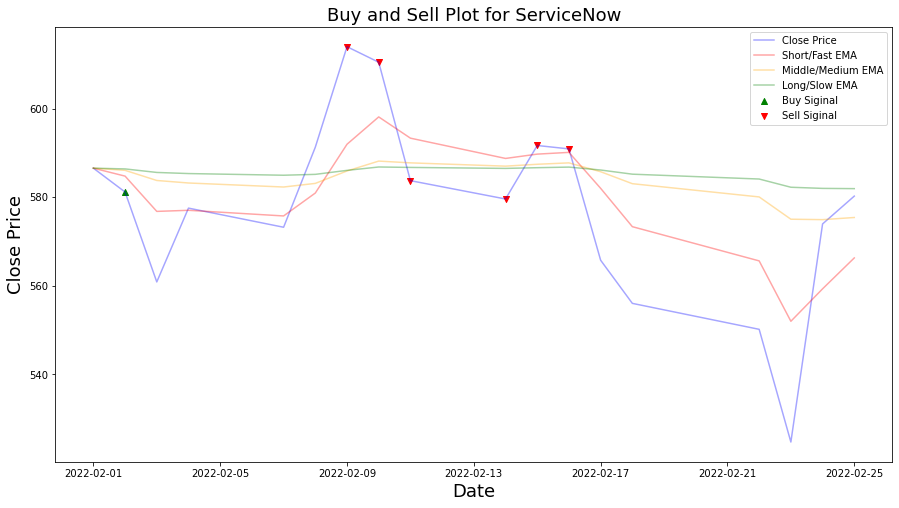

uploaded ServiceNow.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/2_positive/ServiceNow.png
[*********************100%***********************]  1 of 1 completed


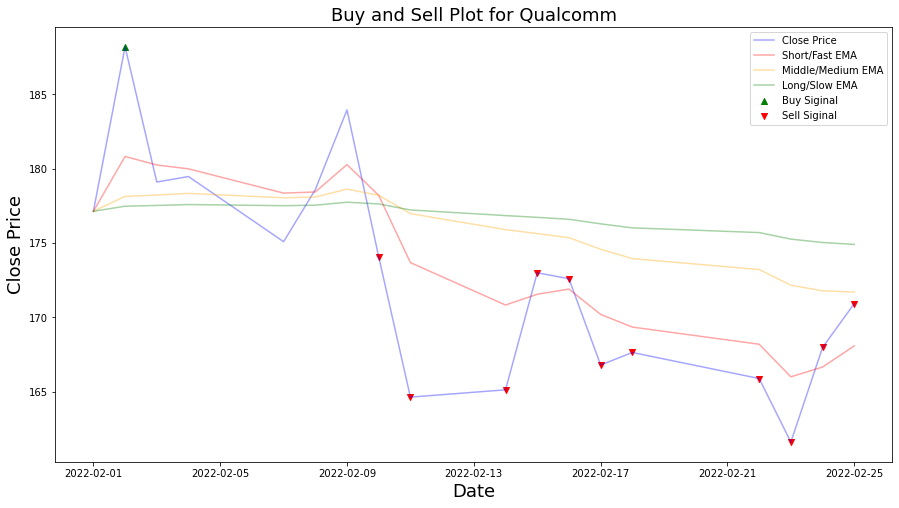

uploaded Qualcomm.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/2_positive/Qualcomm.png
[*********************100%***********************]  1 of 1 completed


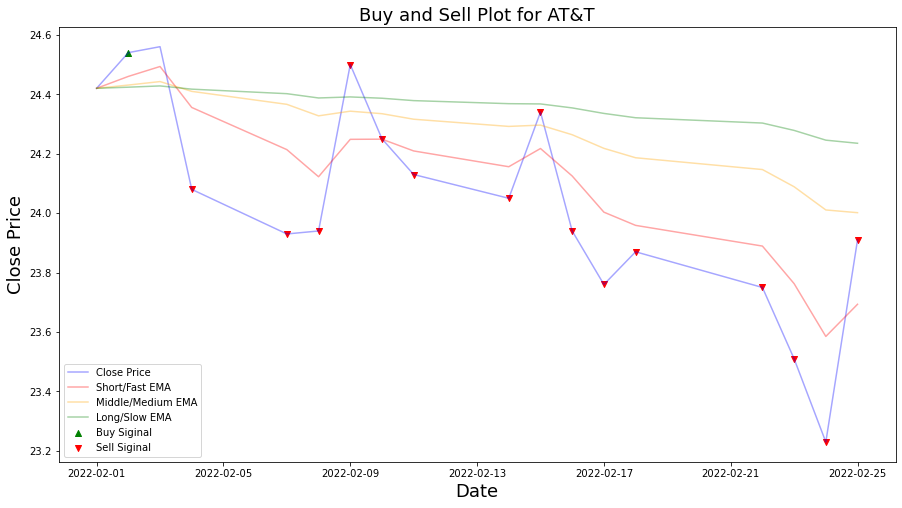

uploaded AT&T.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/2_positive/AT&T.png
[*********************100%***********************]  1 of 1 completed


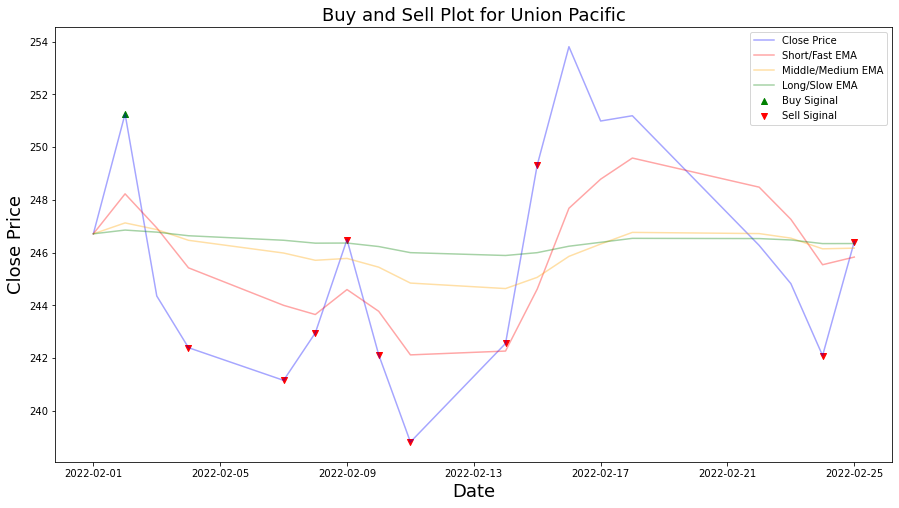

uploaded Union Pacific.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/2_positive/Union Pacific.png
[*********************100%***********************]  1 of 1 completed


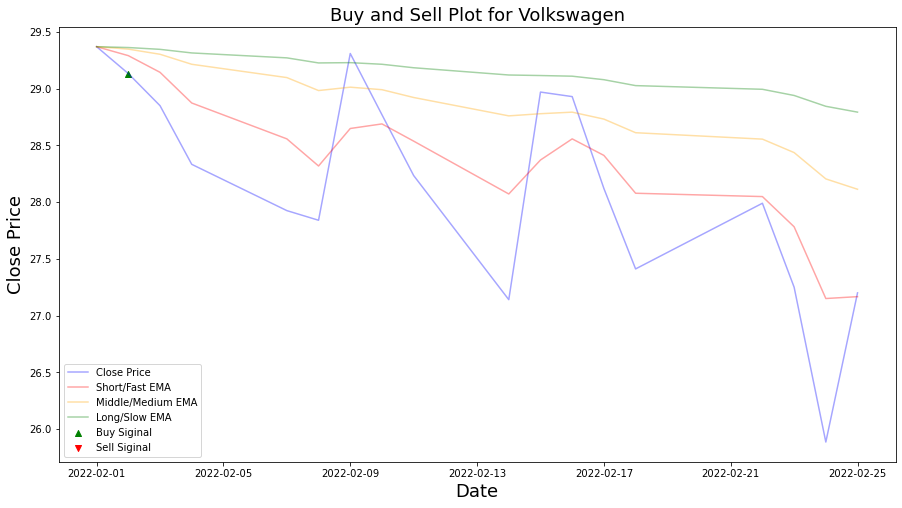

uploaded Volkswagen.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/2_positive/Volkswagen.png
[*********************100%***********************]  1 of 1 completed


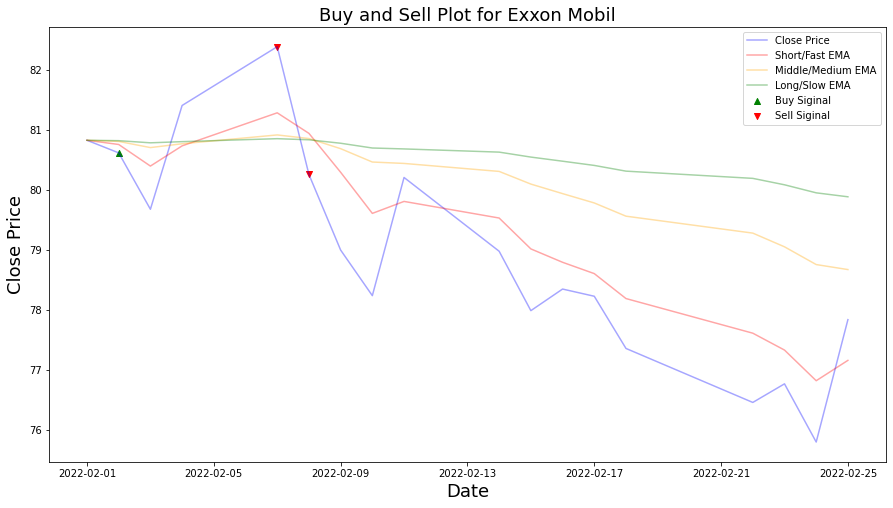

uploaded Exxon Mobil.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/2_positive/Exxon Mobil.png
[*********************100%***********************]  1 of 1 completed


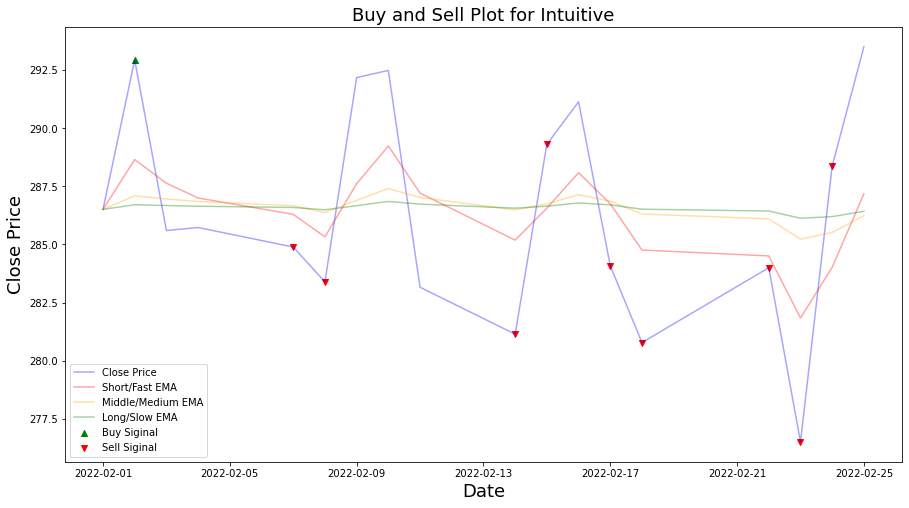

uploaded Intuitive.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/2_positive/Intuitive.png


In [10]:
moving_avarage_analysis(positive_list, 2)

[*********************100%***********************]  1 of 1 completed


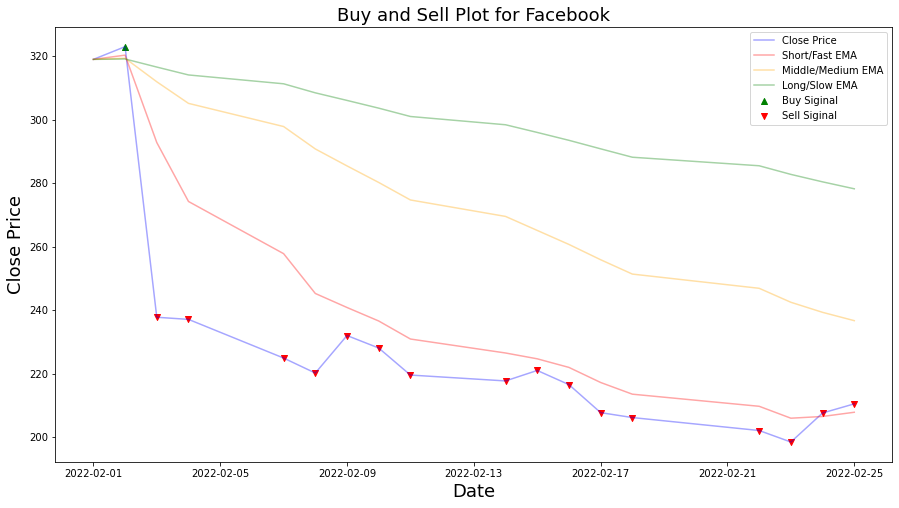

uploaded Facebook.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Facebook.png
[*********************100%***********************]  1 of 1 completed


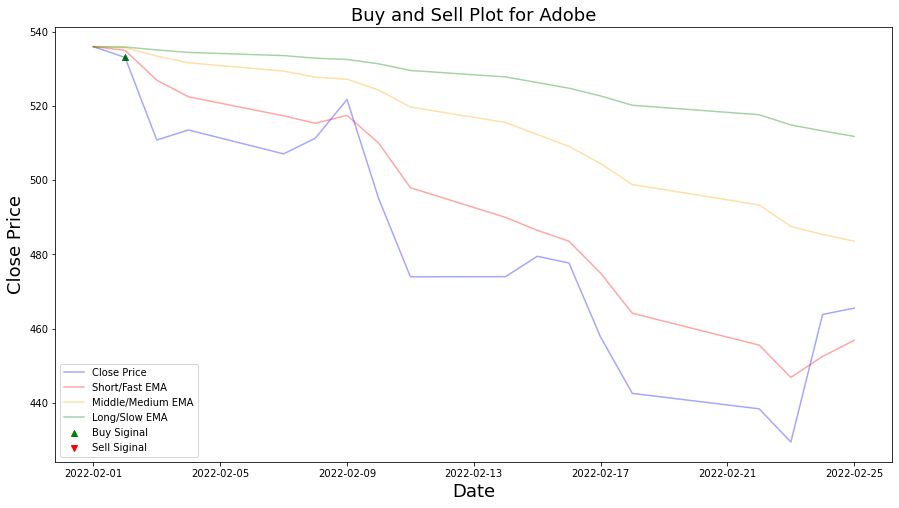

uploaded Adobe.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Adobe.png
[*********************100%***********************]  1 of 1 completed


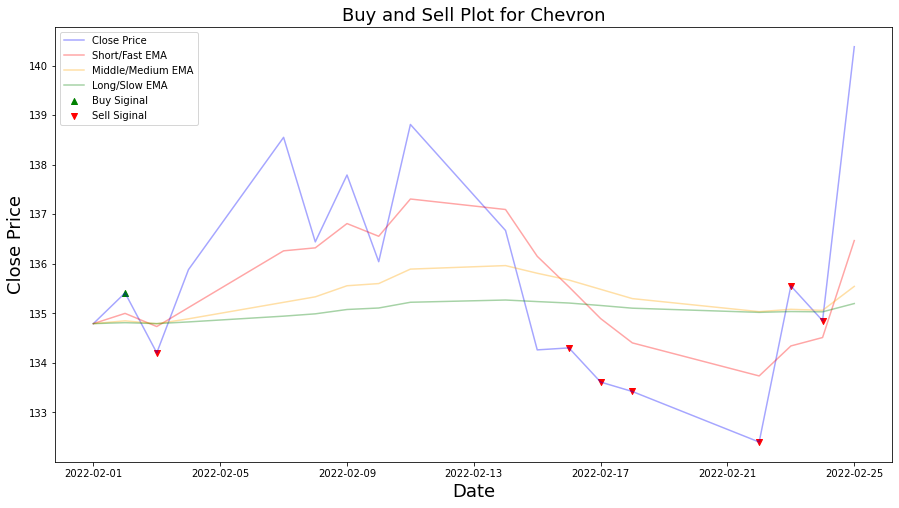

uploaded Chevron.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Chevron.png
[*********************100%***********************]  1 of 1 completed


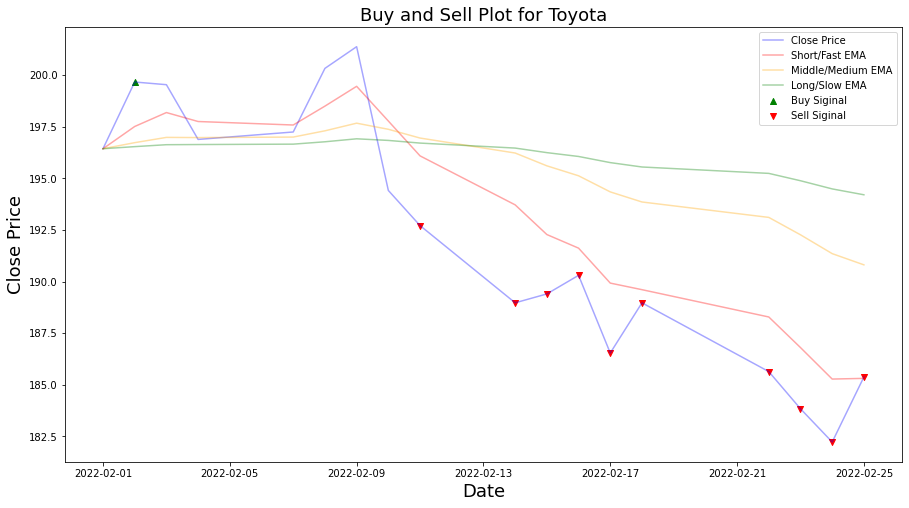

uploaded Toyota.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Toyota.png
[*********************100%***********************]  1 of 1 completed


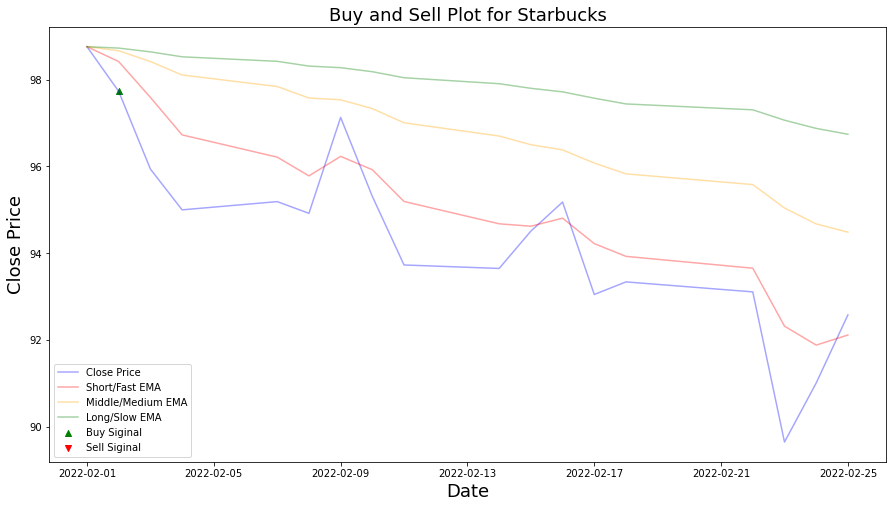

uploaded Starbucks.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Starbucks.png
[*********************100%***********************]  1 of 1 completed


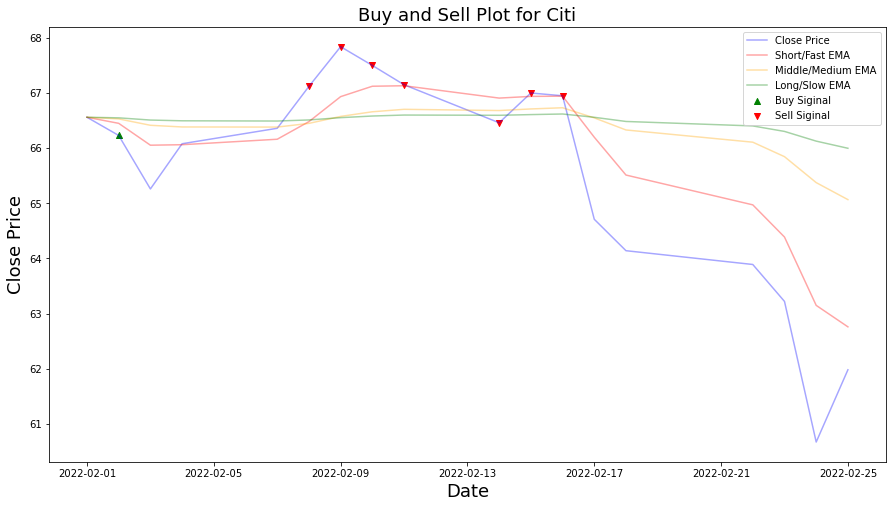

uploaded Citi.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Citi.png
[*********************100%***********************]  1 of 1 completed


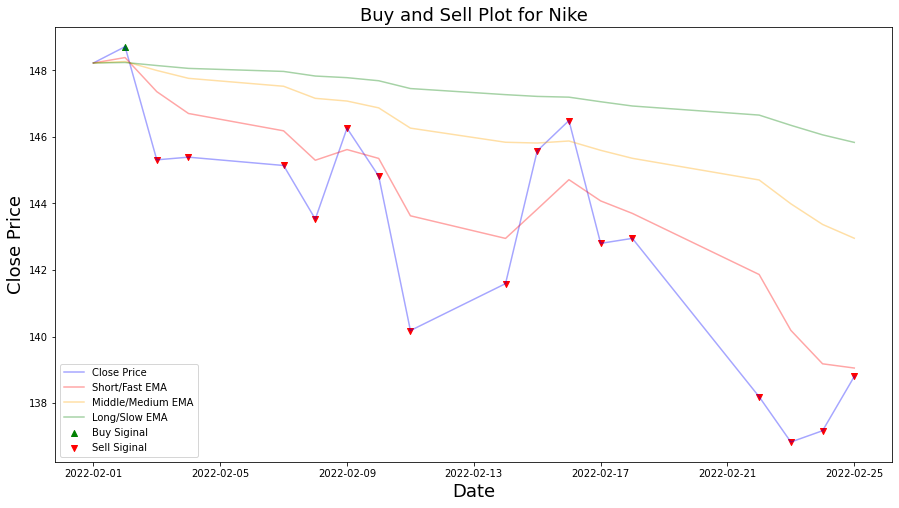

uploaded Nike.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Nike.png
[*********************100%***********************]  1 of 1 completed


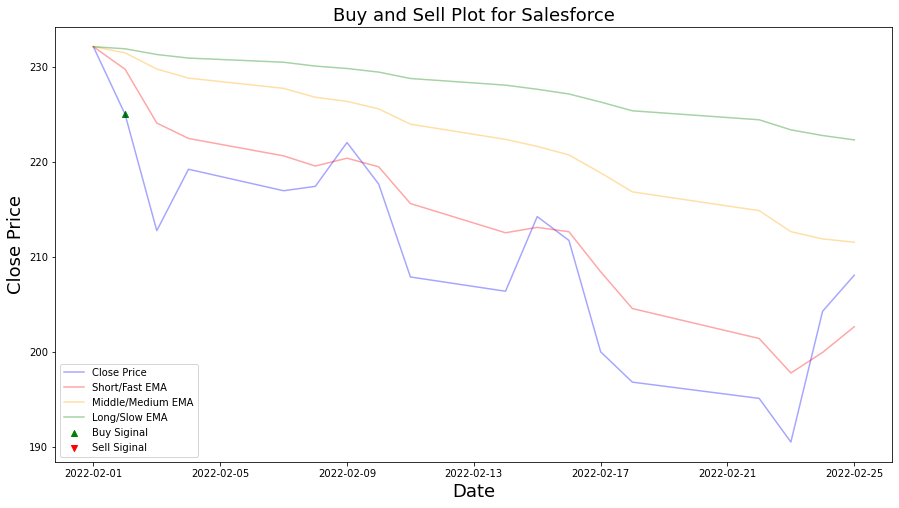

uploaded Salesforce.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Salesforce.png
[*********************100%***********************]  1 of 1 completed


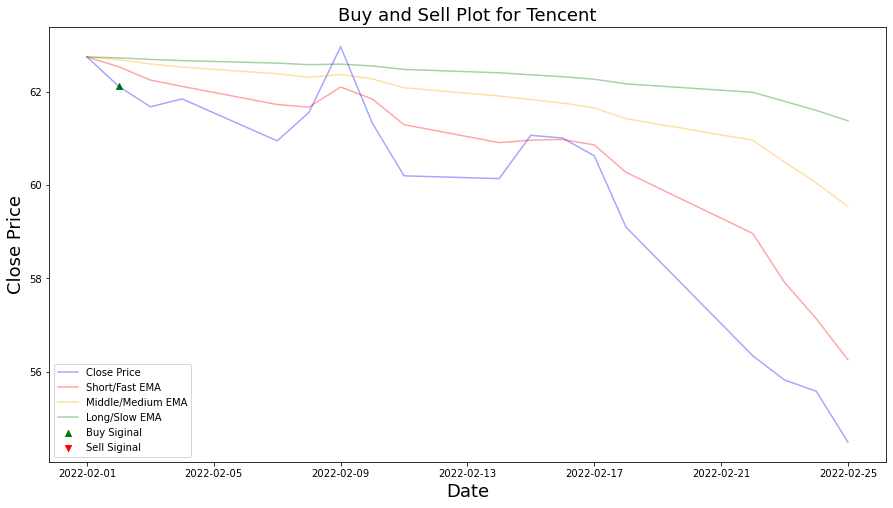

uploaded Tencent.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Tencent.png
[*********************100%***********************]  1 of 1 completed


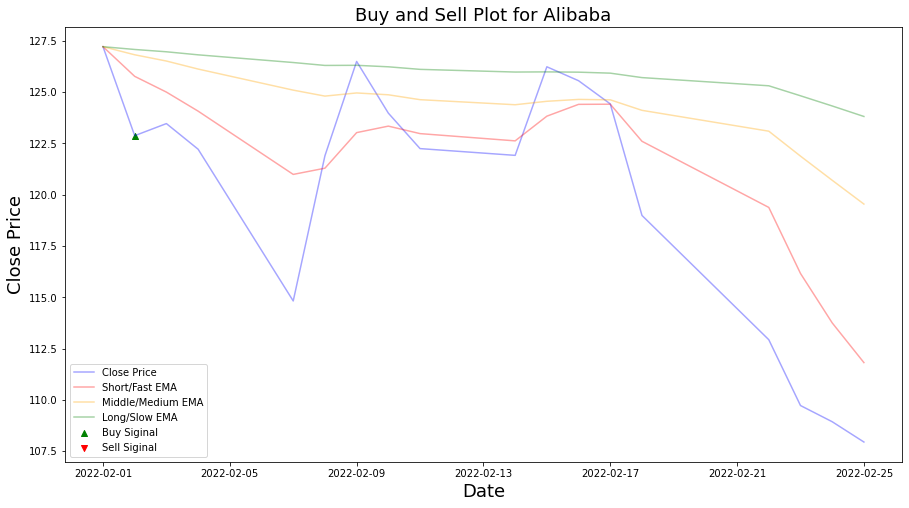

uploaded Alibaba.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Alibaba.png
[*********************100%***********************]  1 of 1 completed


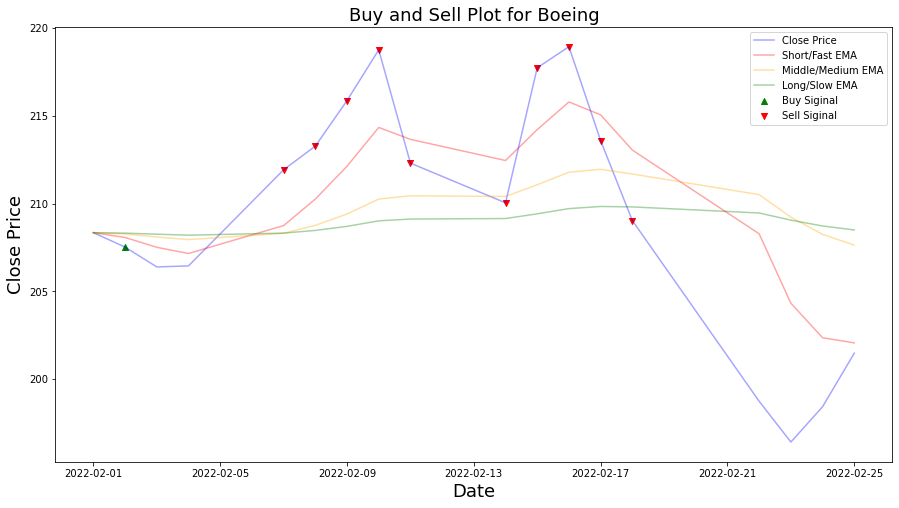

uploaded Boeing.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Boeing.png
[*********************100%***********************]  1 of 1 completed


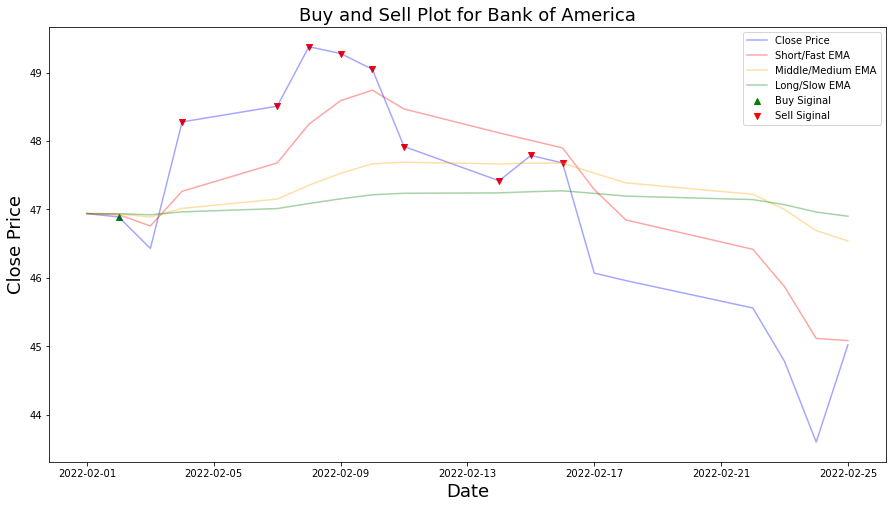

uploaded Bank of America.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Bank of America.png
[*********************100%***********************]  1 of 1 completed


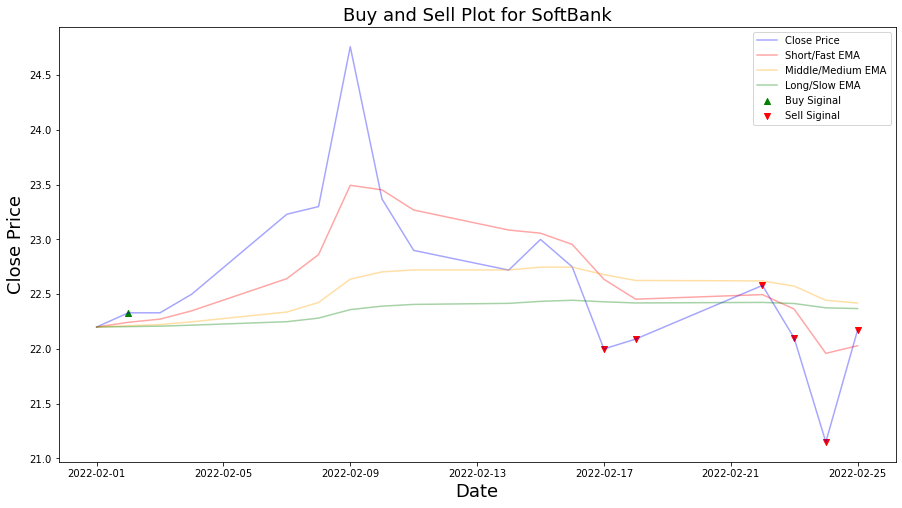

uploaded SoftBank.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/SoftBank.png
[*********************100%***********************]  1 of 1 completed


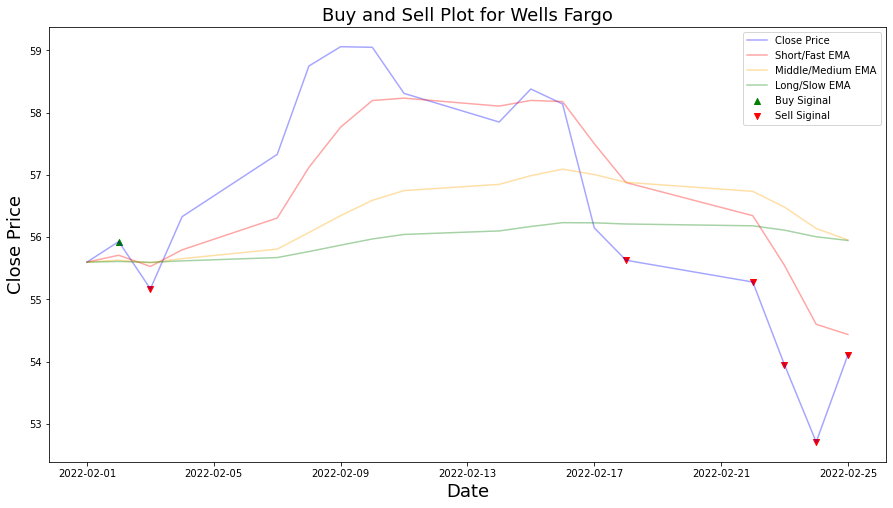

uploaded Wells Fargo.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Wells Fargo.png
[*********************100%***********************]  1 of 1 completed


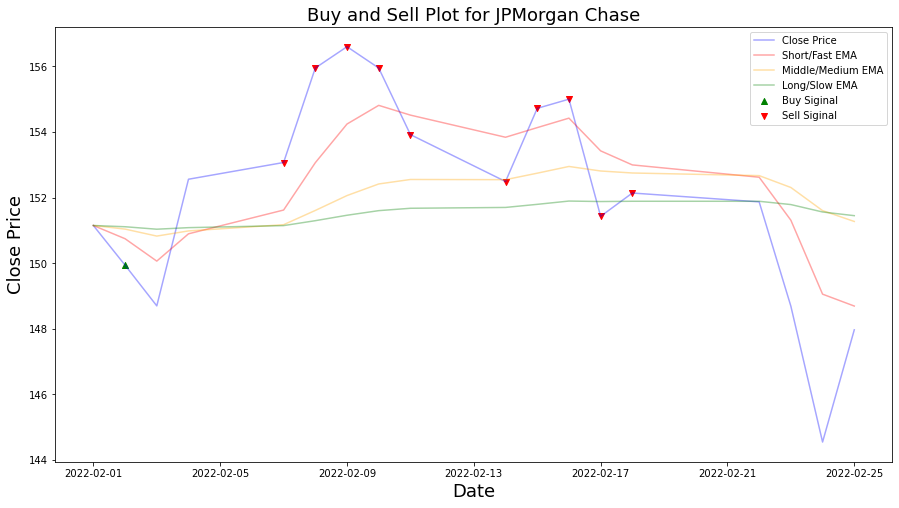

uploaded JPMorgan Chase.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/JPMorgan Chase.png
[*********************100%***********************]  1 of 1 completed


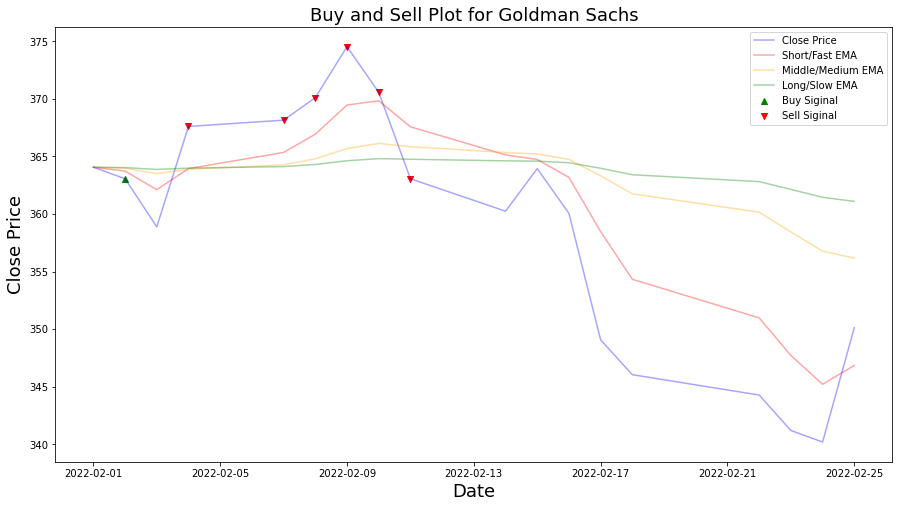

uploaded Goldman Sachs.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/3_weak_positive/Goldman Sachs.png


In [11]:
moving_avarage_analysis(wpositive_list, 3)

[*********************100%***********************]  1 of 1 completed


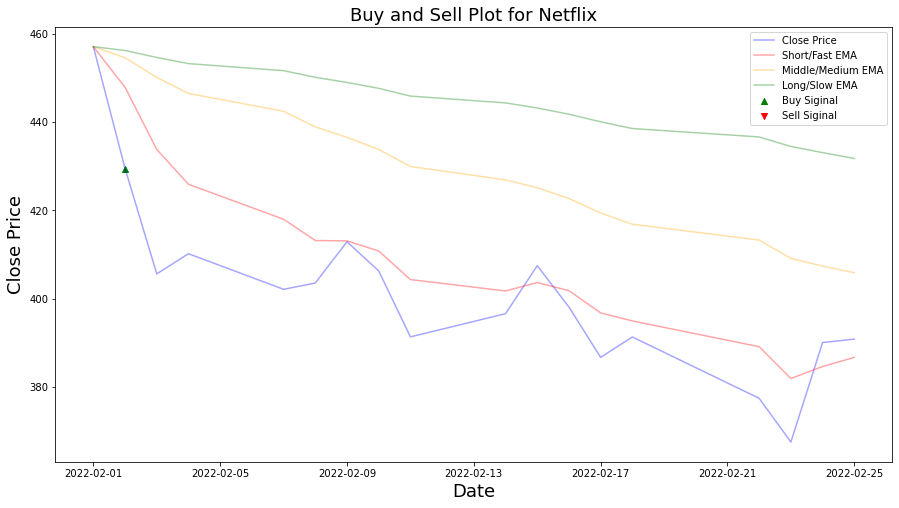

uploaded Netflix.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Netflix.png
[*********************100%***********************]  1 of 1 completed


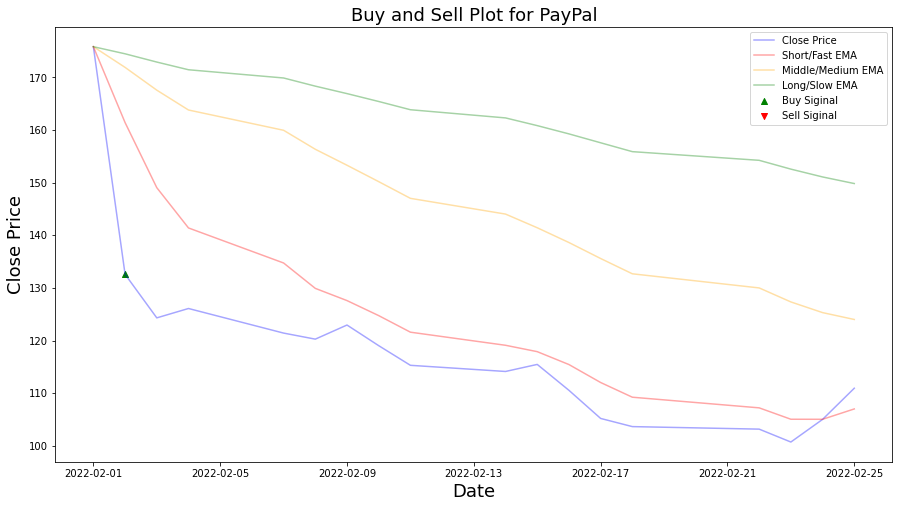

uploaded PayPal.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/PayPal.png
[*********************100%***********************]  1 of 1 completed


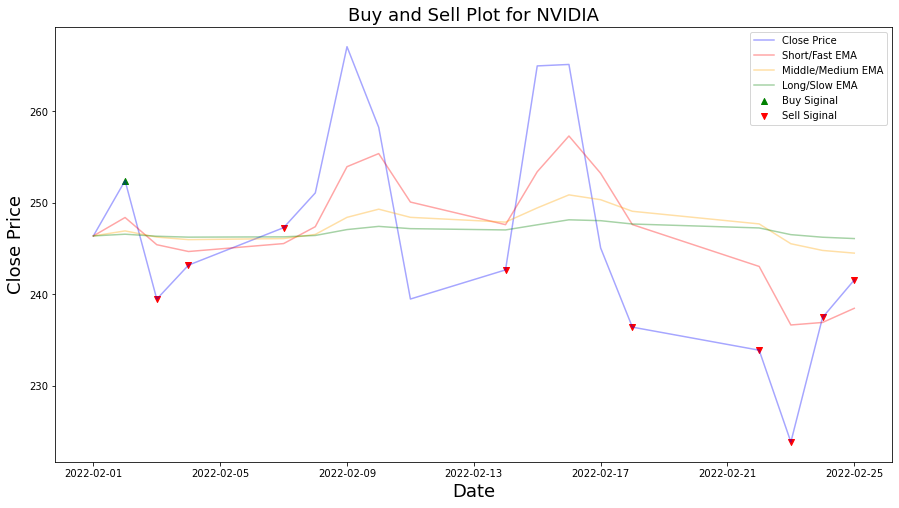

uploaded NVIDIA.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/NVIDIA.png
[*********************100%***********************]  1 of 1 completed


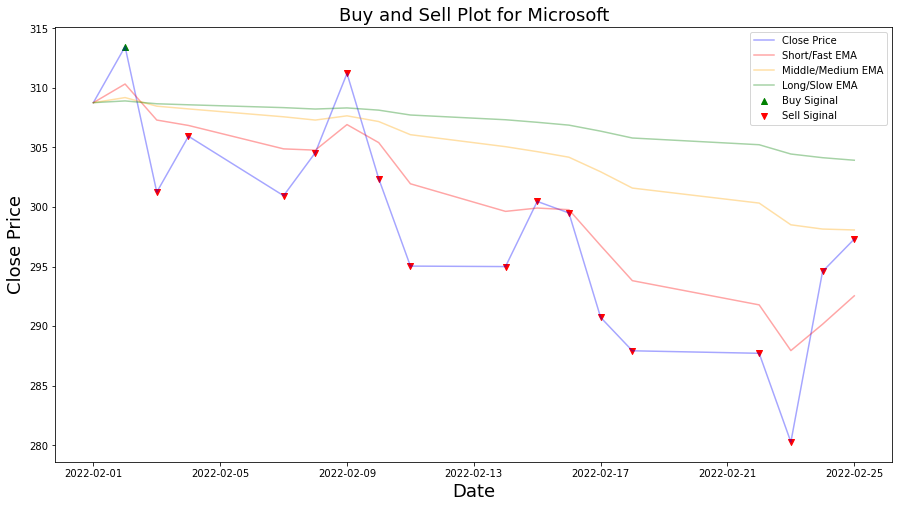

uploaded Microsoft.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Microsoft.png
[*********************100%***********************]  1 of 1 completed


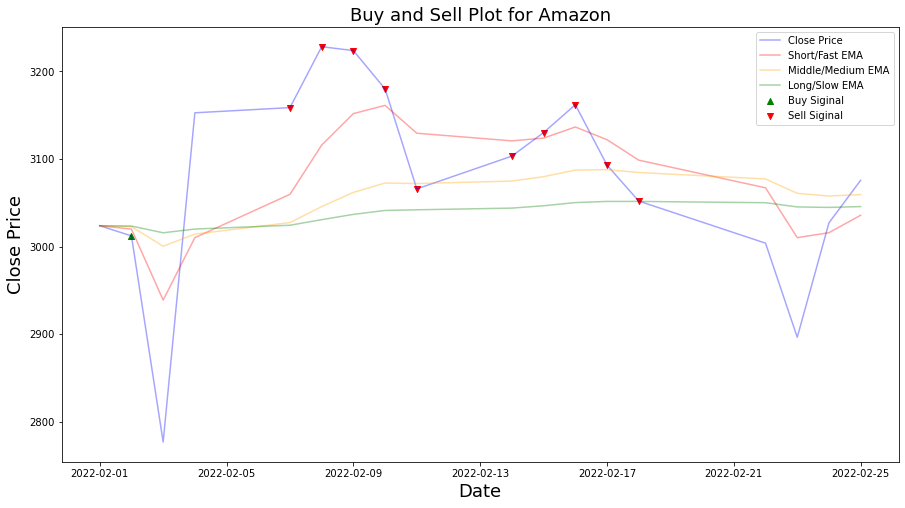

uploaded Amazon.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Amazon.png
[*********************100%***********************]  1 of 1 completed


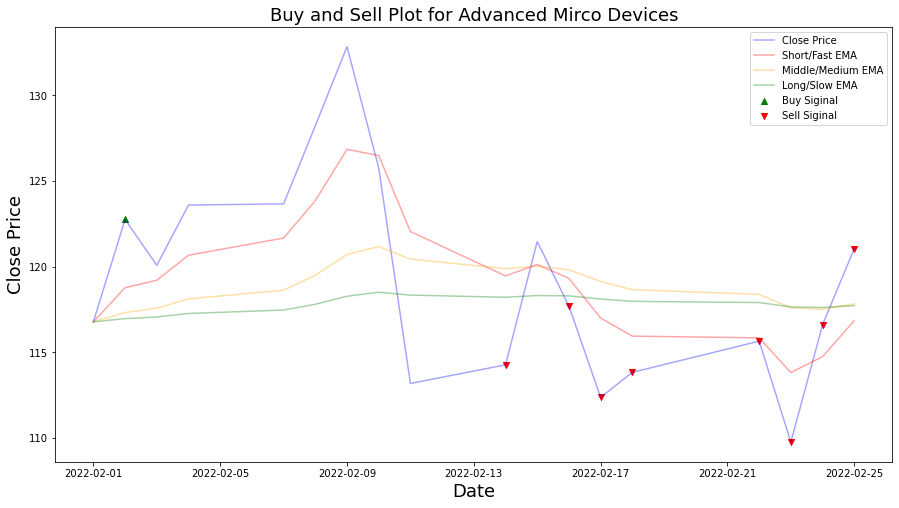

uploaded Advanced Mirco Devices.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Advanced Mirco Devices.png
[*********************100%***********************]  1 of 1 completed


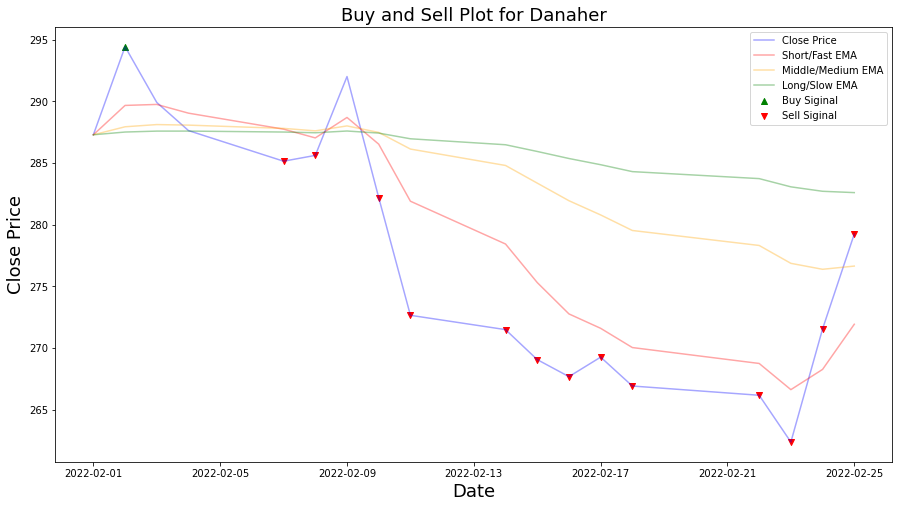

uploaded Danaher.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Danaher.png
[*********************100%***********************]  1 of 1 completed


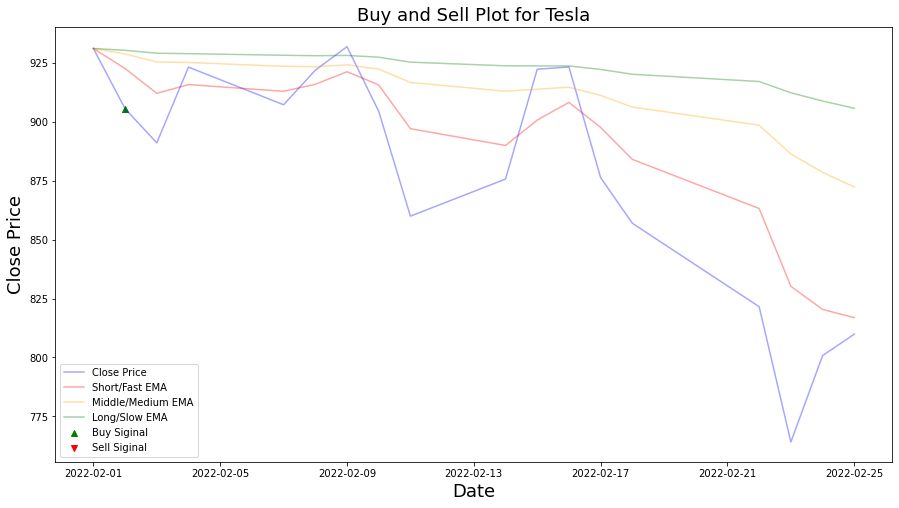

uploaded Tesla.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Tesla.png
[*********************100%***********************]  1 of 1 completed


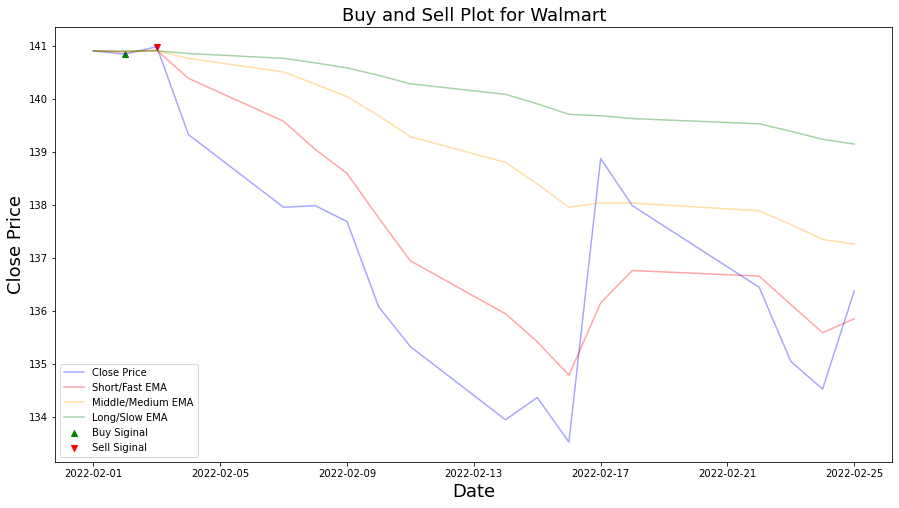

uploaded Walmart.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Walmart.png
[*********************100%***********************]  1 of 1 completed


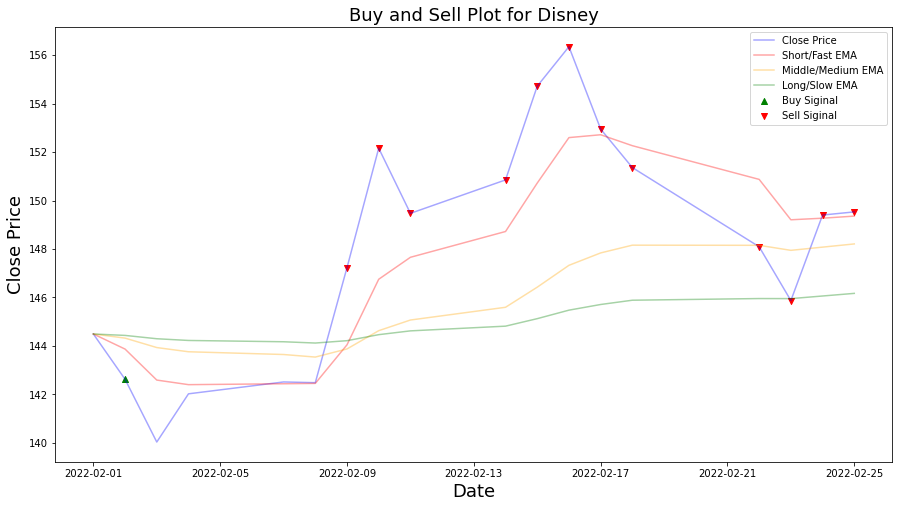

uploaded Disney.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Disney.png
[*********************100%***********************]  1 of 1 completed


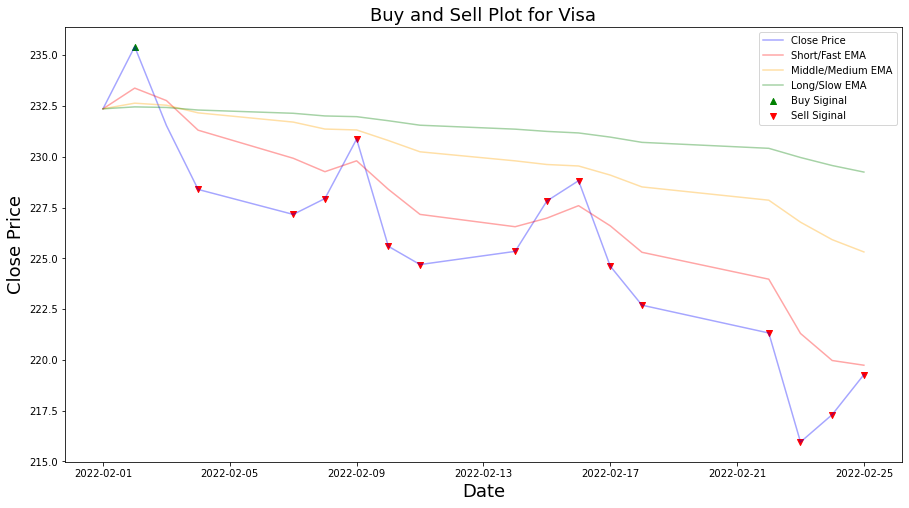

uploaded Visa.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Visa.png
[*********************100%***********************]  1 of 1 completed


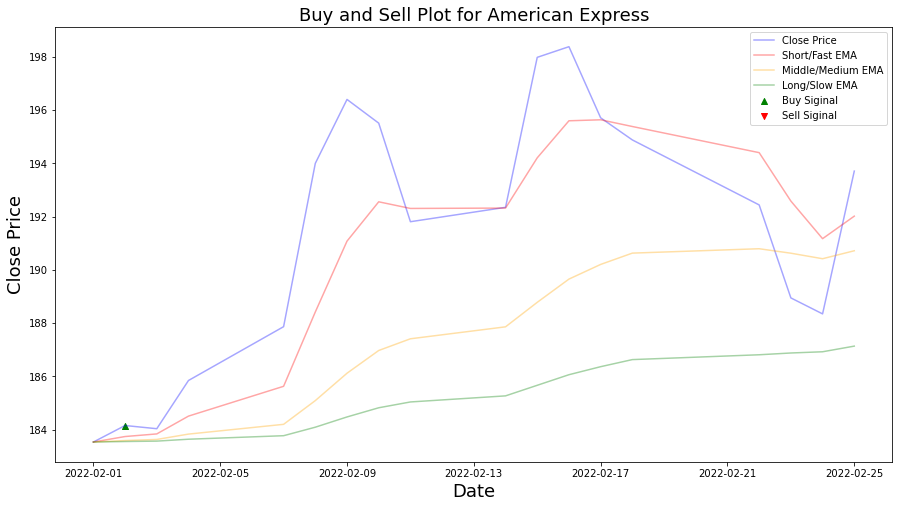

uploaded American Express.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/American Express.png
[*********************100%***********************]  1 of 1 completed


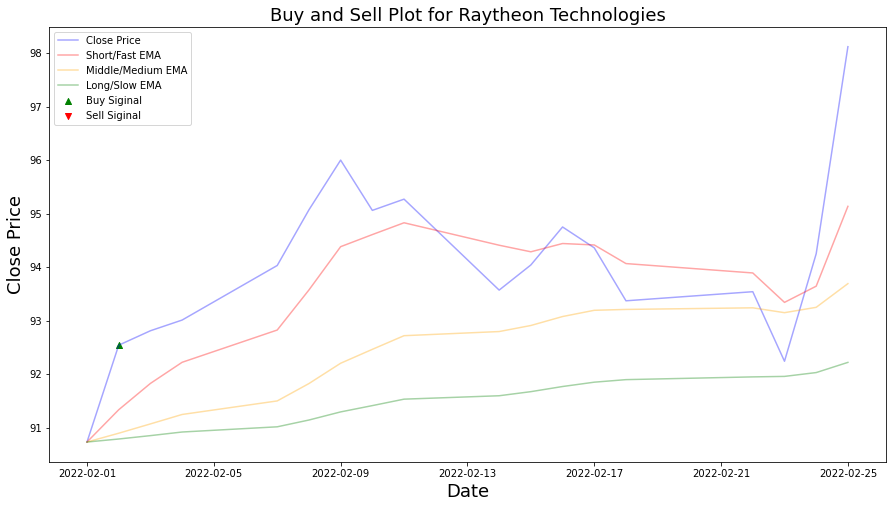

uploaded Raytheon Technologies.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Raytheon Technologies.png
[*********************100%***********************]  1 of 1 completed


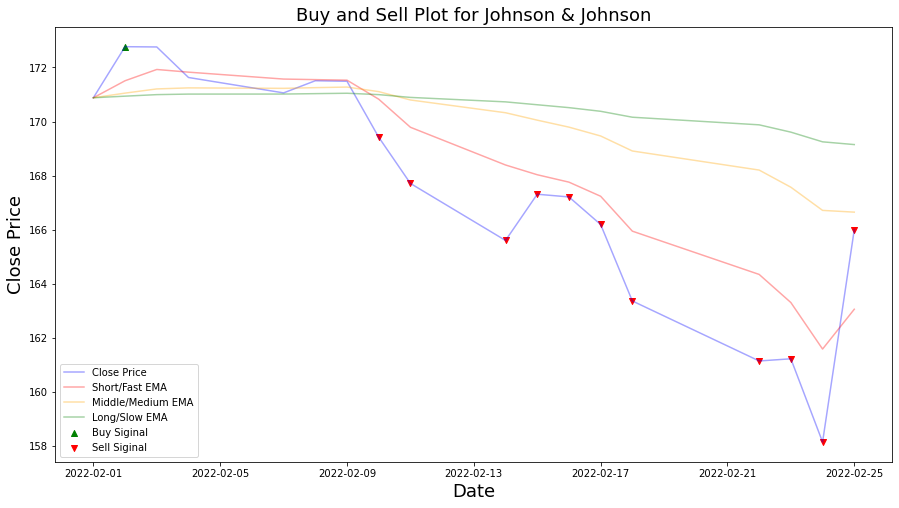

uploaded Johnson & Johnson.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Johnson & Johnson.png
[*********************100%***********************]  1 of 1 completed


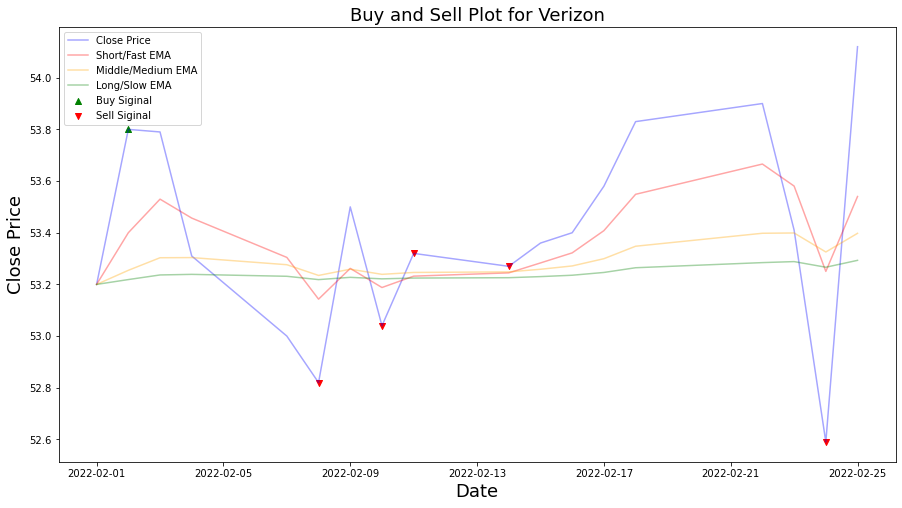

uploaded Verizon.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Verizon.png
[*********************100%***********************]  1 of 1 completed


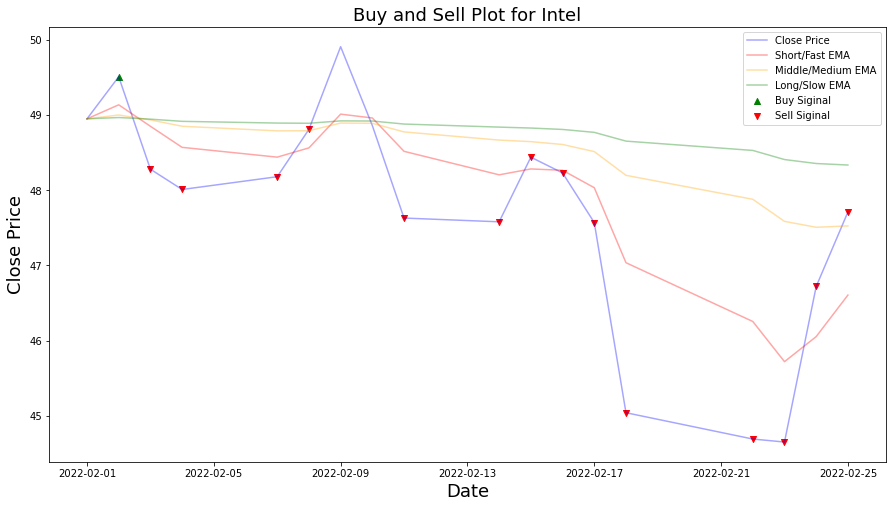

uploaded Intel.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Intel.png
[*********************100%***********************]  1 of 1 completed


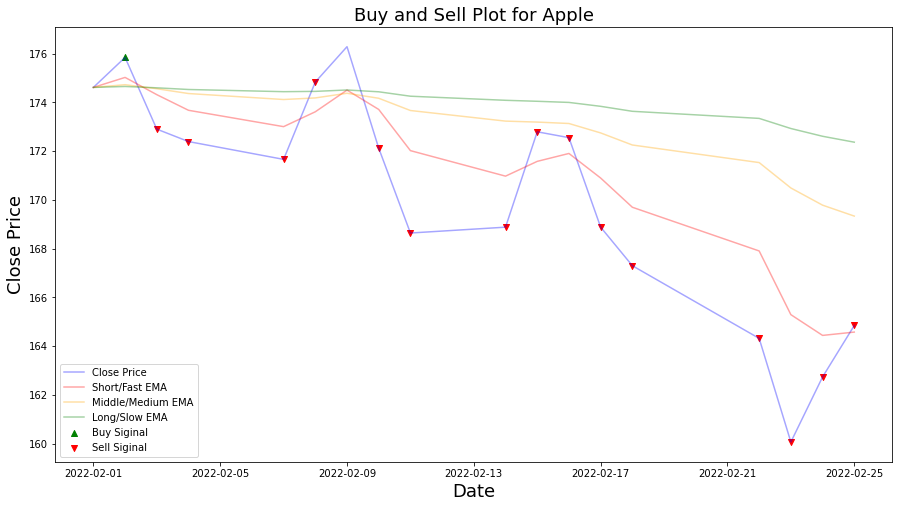

uploaded Apple.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Apple.png
[*********************100%***********************]  1 of 1 completed


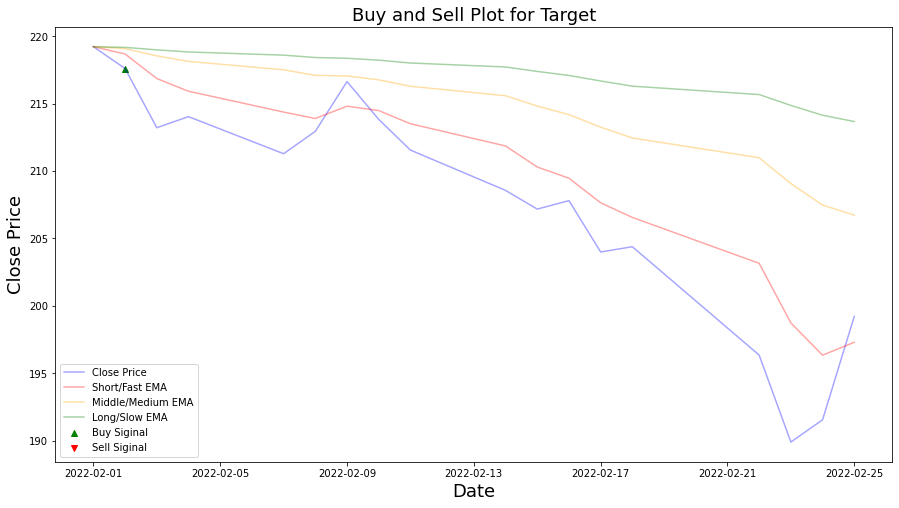

uploaded Target.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Target.png
[*********************100%***********************]  1 of 1 completed


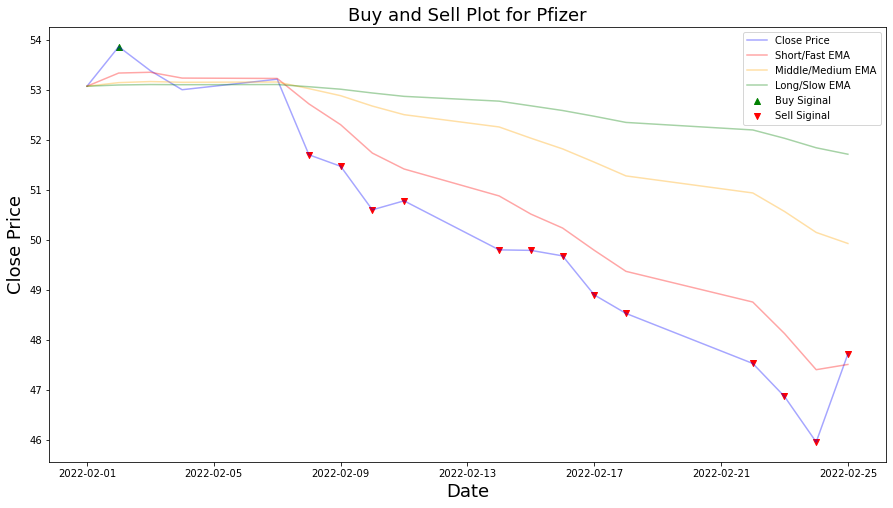

uploaded Pfizer.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Pfizer.png
[*********************100%***********************]  1 of 1 completed


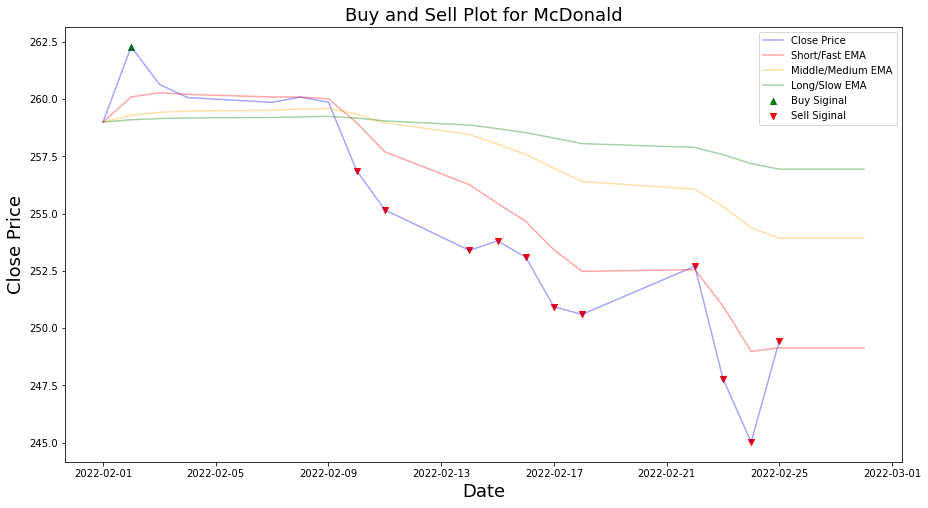

uploaded McDonald.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/McDonald.png
[*********************100%***********************]  1 of 1 completed


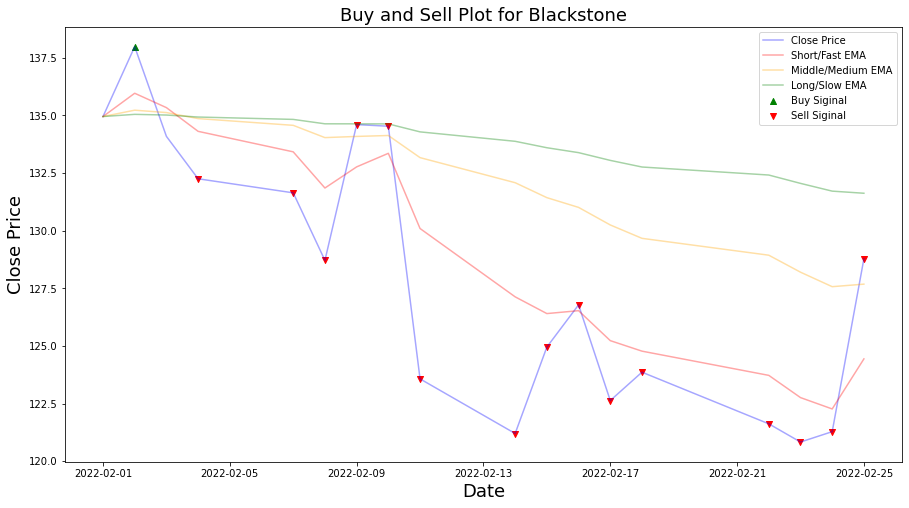

uploaded Blackstone.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Blackstone.png
[*********************100%***********************]  1 of 1 completed


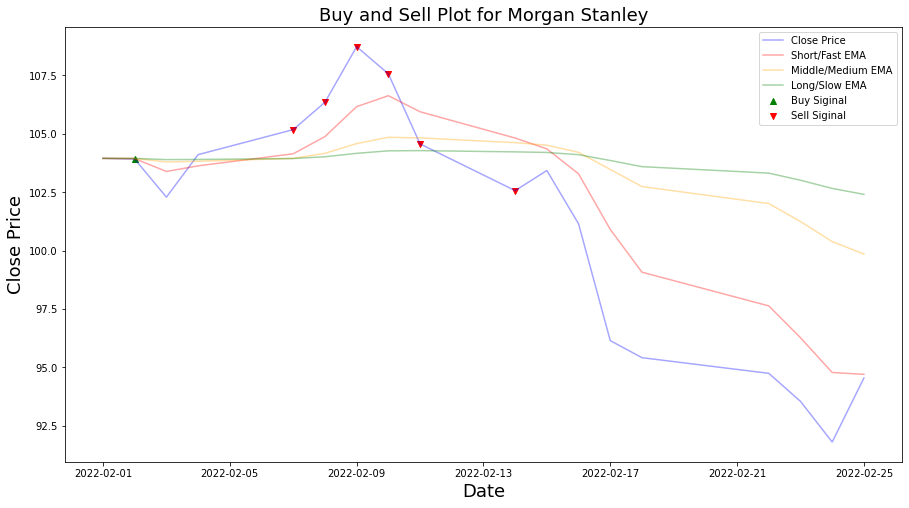

uploaded Morgan Stanley.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Morgan Stanley.png
[*********************100%***********************]  1 of 1 completed


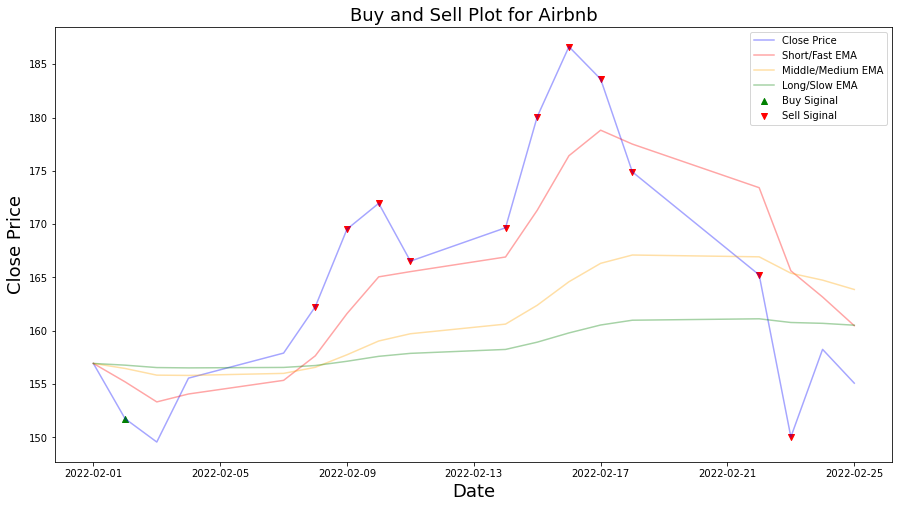

uploaded Airbnb.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Airbnb.png
[*********************100%***********************]  1 of 1 completed


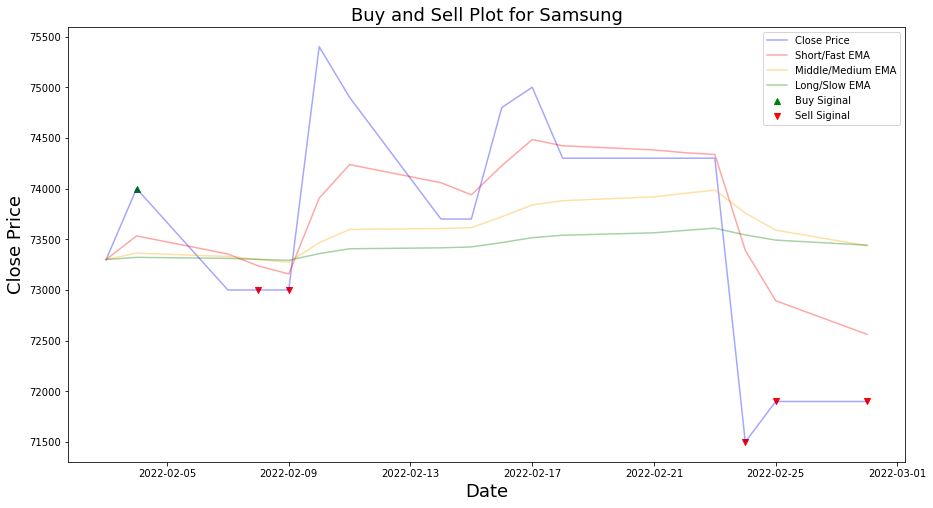

uploaded Samsung.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Samsung.png
[*********************100%***********************]  1 of 1 completed


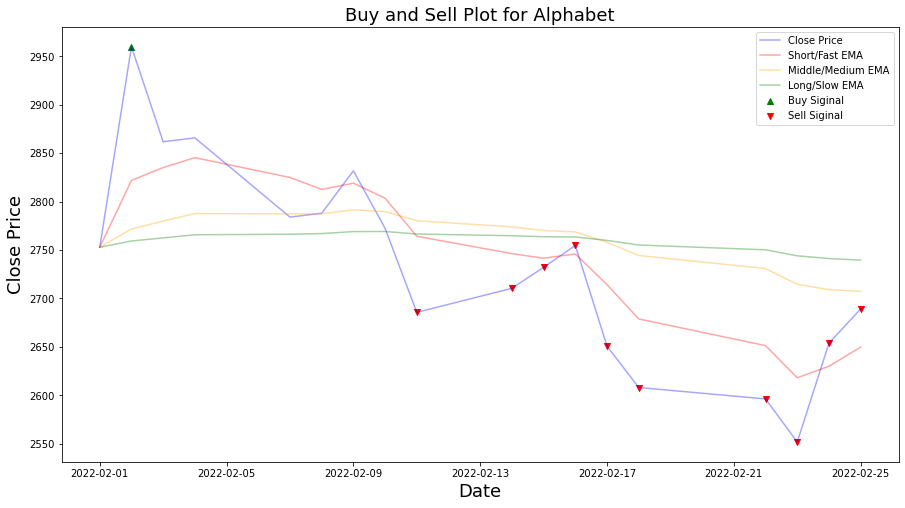

uploaded Alphabet.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Alphabet.png
[*********************100%***********************]  1 of 1 completed


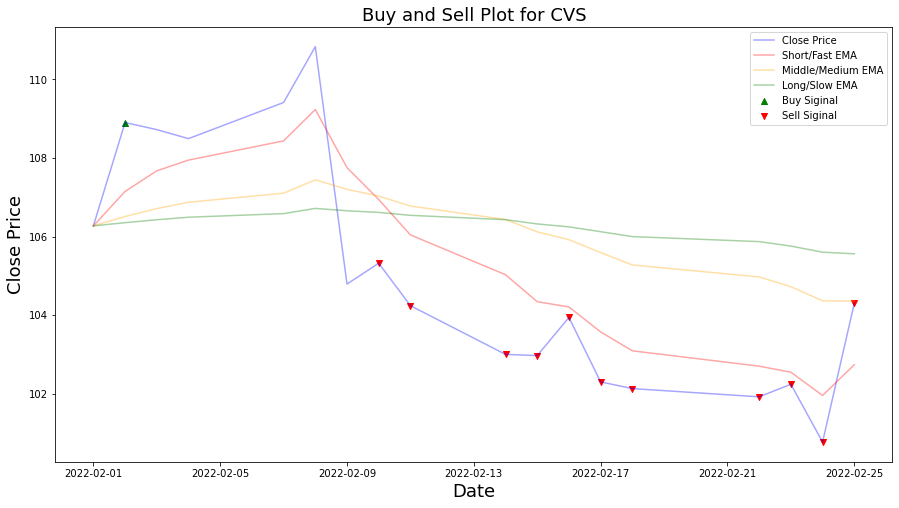

uploaded CVS.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/CVS.png
[*********************100%***********************]  1 of 1 completed


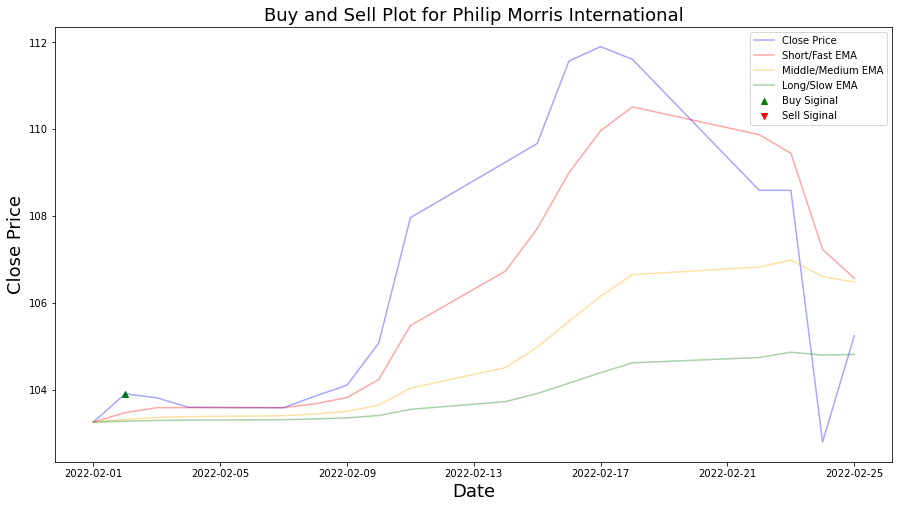

uploaded Philip Morris International.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Philip Morris International.png
[*********************100%***********************]  1 of 1 completed


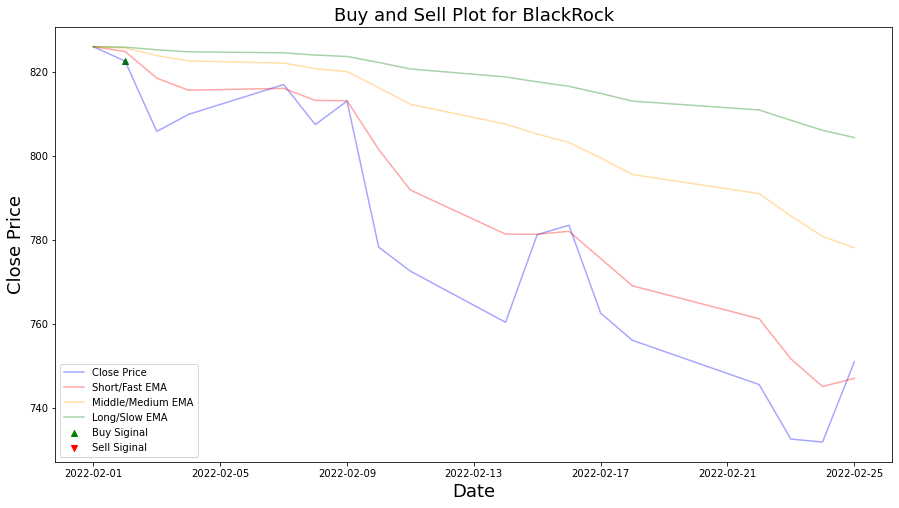

uploaded BlackRock.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/BlackRock.png
[*********************100%***********************]  1 of 1 completed


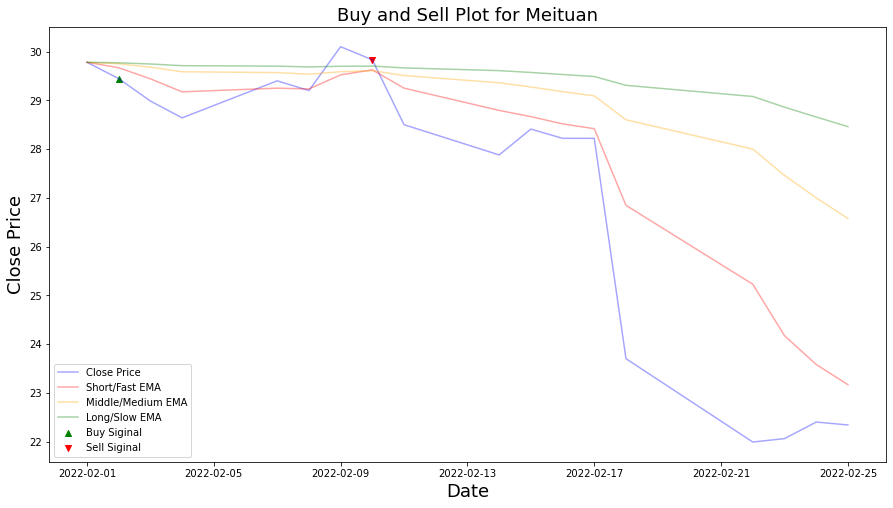

uploaded Meituan.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Meituan.png
[*********************100%***********************]  1 of 1 completed


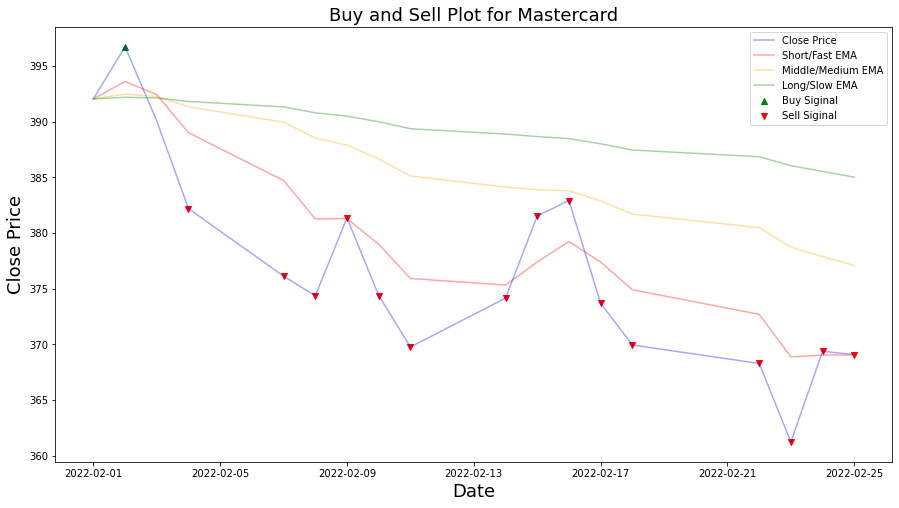

uploaded Mastercard.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Mastercard.png
[*********************100%***********************]  1 of 1 completed


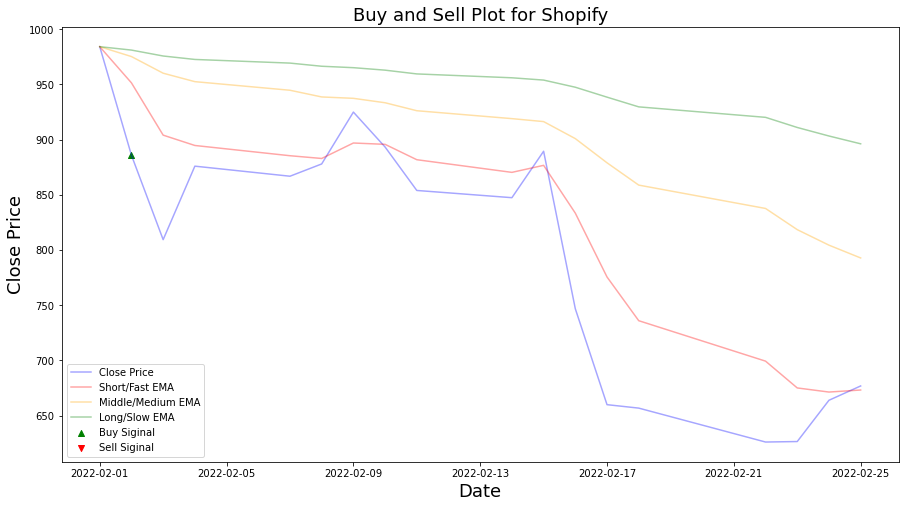

uploaded Shopify.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Shopify.png
[*********************100%***********************]  1 of 1 completed


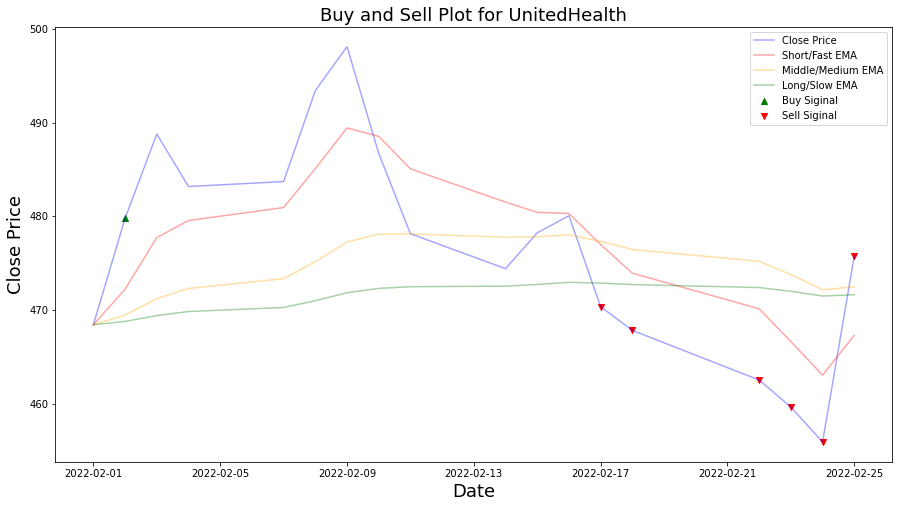

uploaded UnitedHealth.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/UnitedHealth.png
[*********************100%***********************]  1 of 1 completed


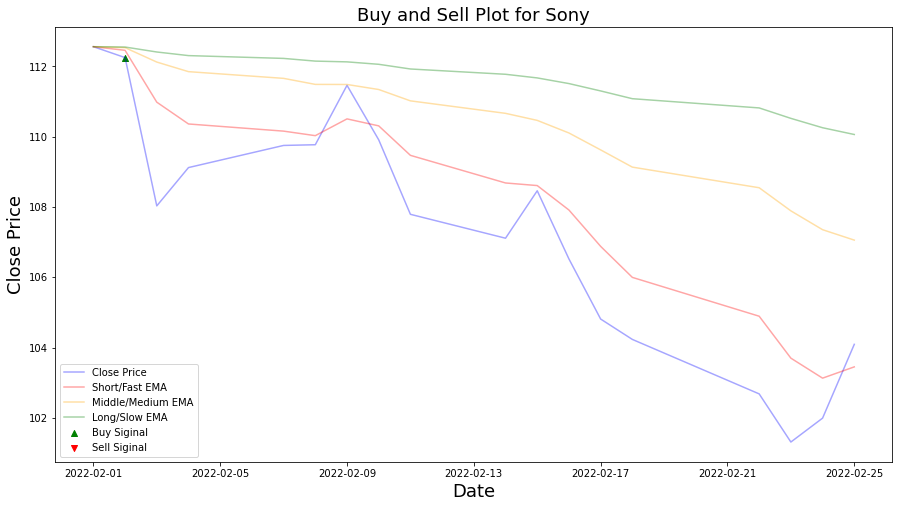

uploaded Sony.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Sony.png
[*********************100%***********************]  1 of 1 completed


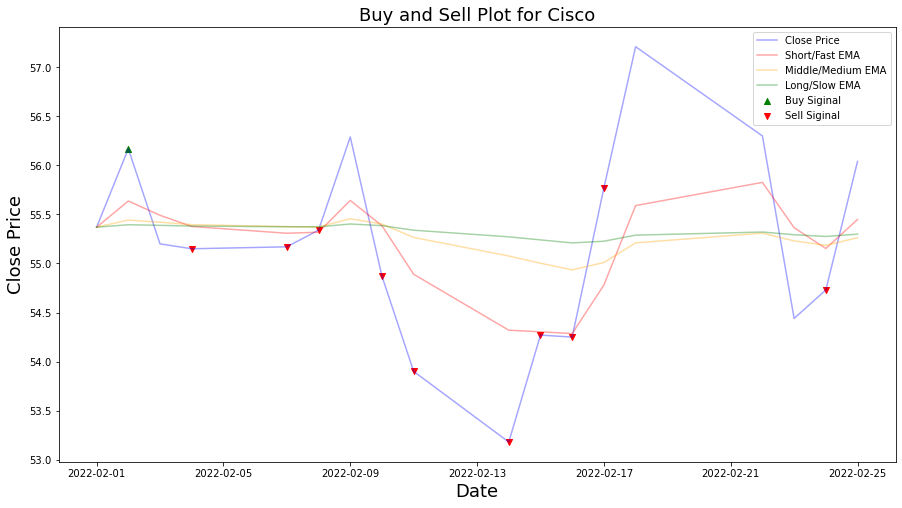

uploaded Cisco.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Cisco.png
[*********************100%***********************]  1 of 1 completed


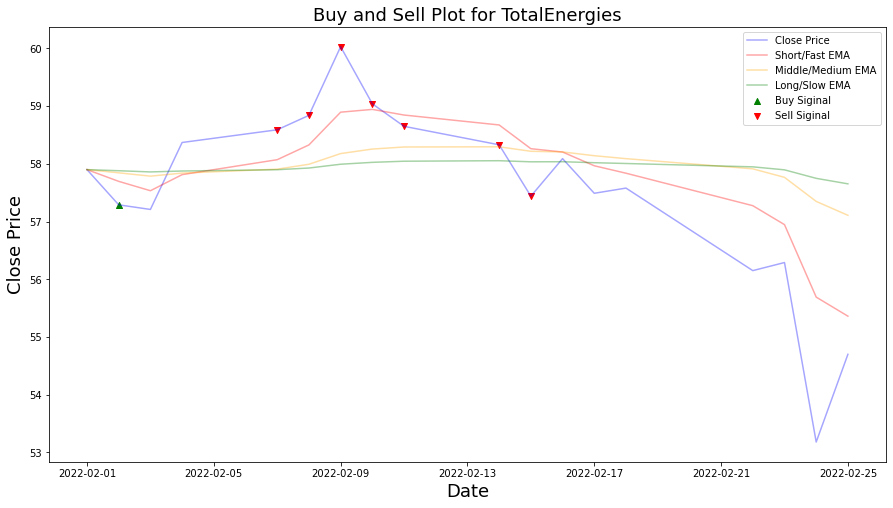

uploaded TotalEnergies.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/TotalEnergies.png
[*********************100%***********************]  1 of 1 completed


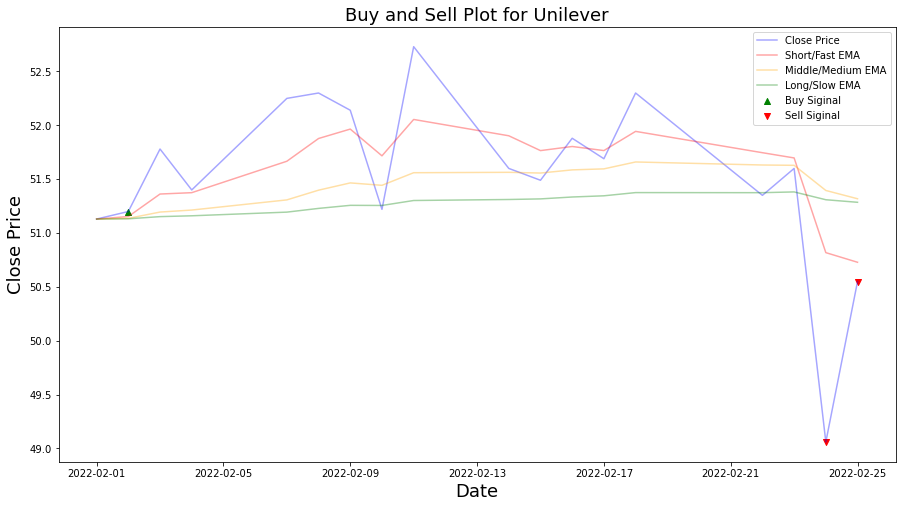

uploaded Unilever.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Unilever.png
[*********************100%***********************]  1 of 1 completed


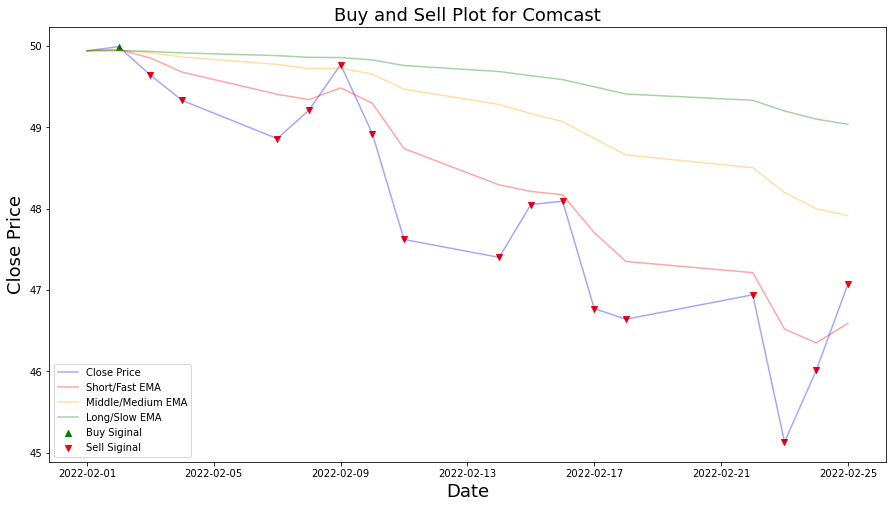

uploaded Comcast.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Comcast.png
[*********************100%***********************]  1 of 1 completed


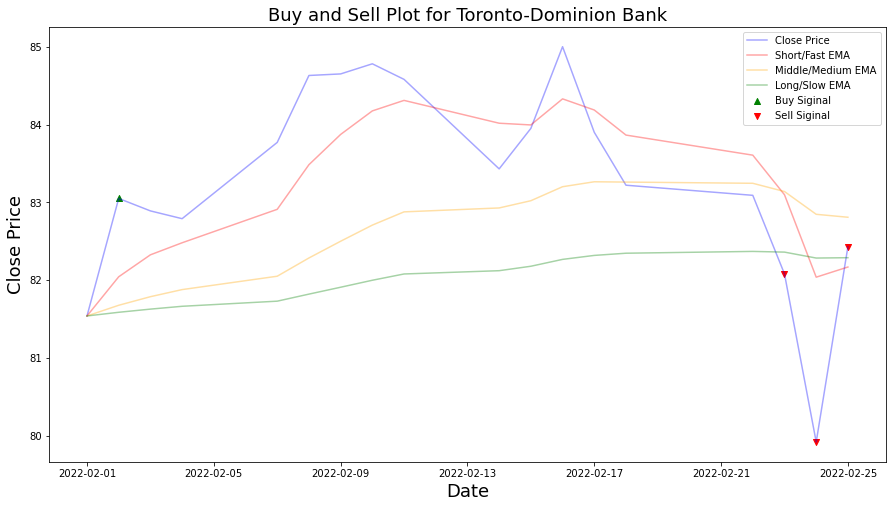

uploaded Toronto-Dominion Bank.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Toronto-Dominion Bank.png
[*********************100%***********************]  1 of 1 completed


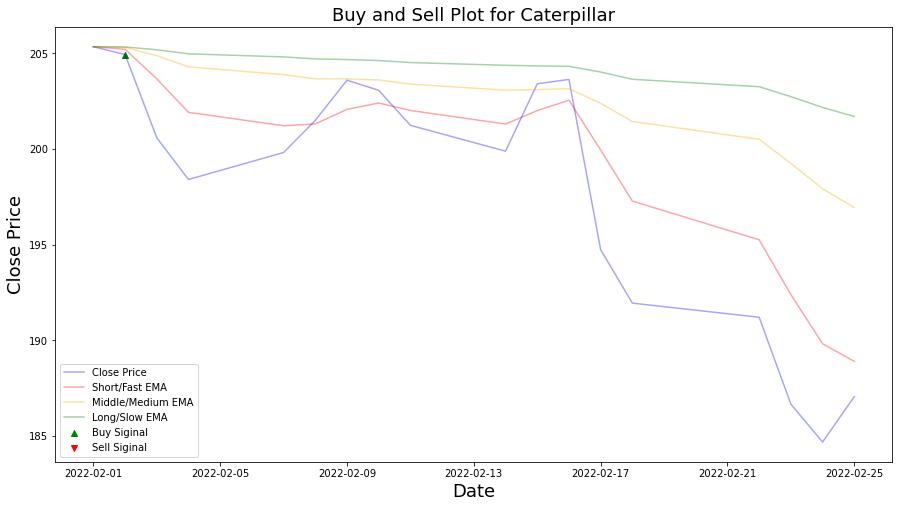

uploaded Caterpillar.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Caterpillar.png
[*********************100%***********************]  1 of 1 completed


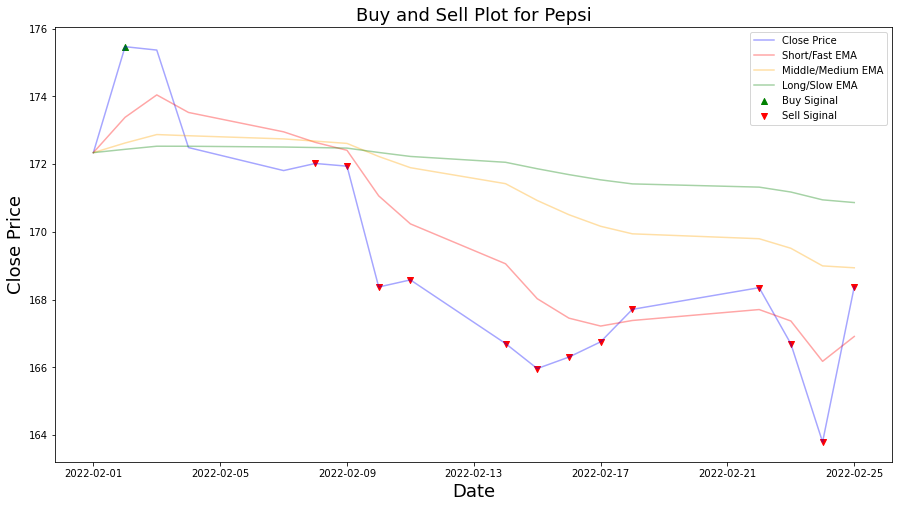

uploaded Pepsi.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Pepsi.png
[*********************100%***********************]  1 of 1 completed


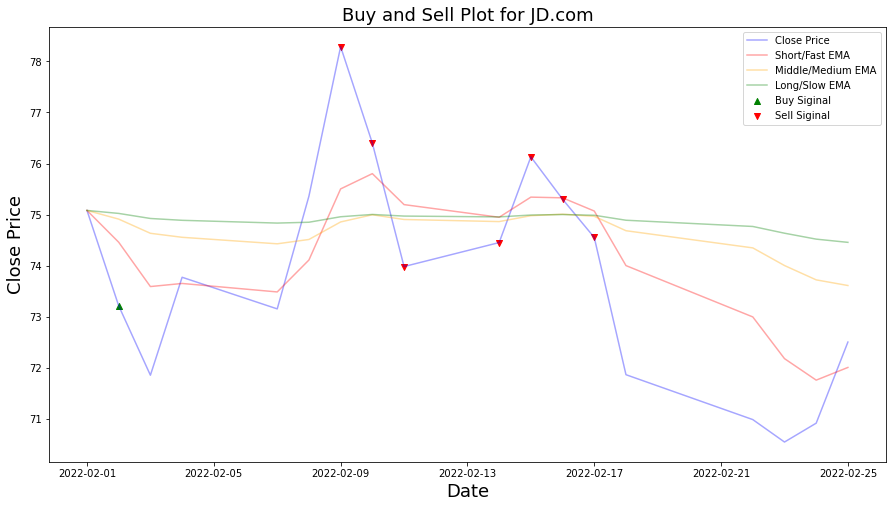

uploaded JD.com.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/JD.com.png
[*********************100%***********************]  1 of 1 completed


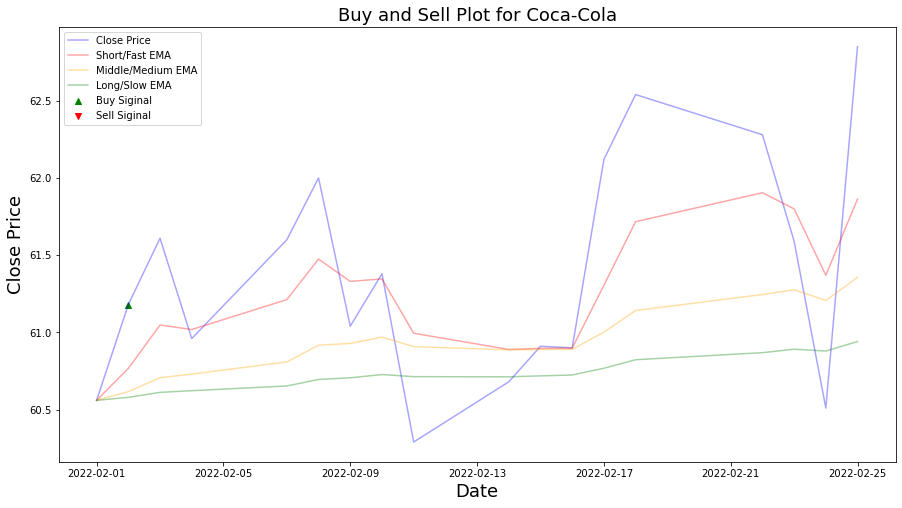

uploaded Coca-Cola.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Coca-Cola.png
[*********************100%***********************]  1 of 1 completed


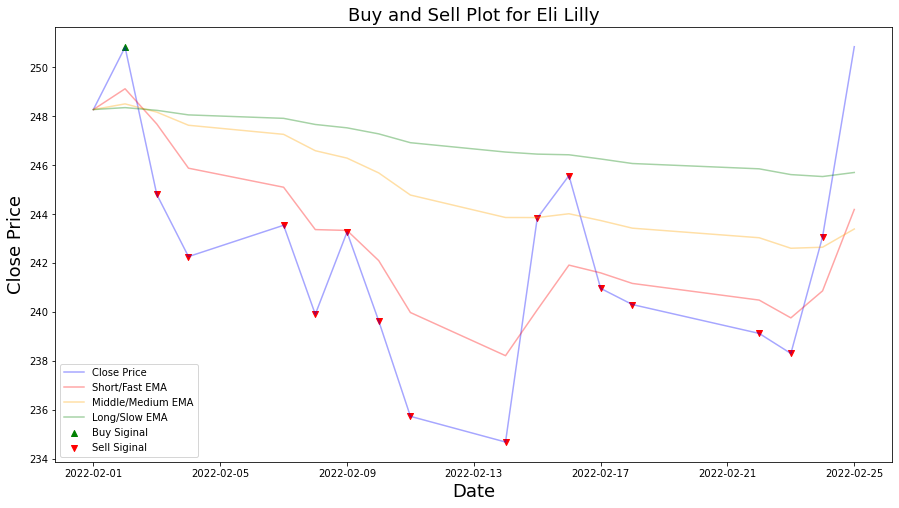

uploaded Eli Lilly.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Eli Lilly.png
[*********************100%***********************]  1 of 1 completed


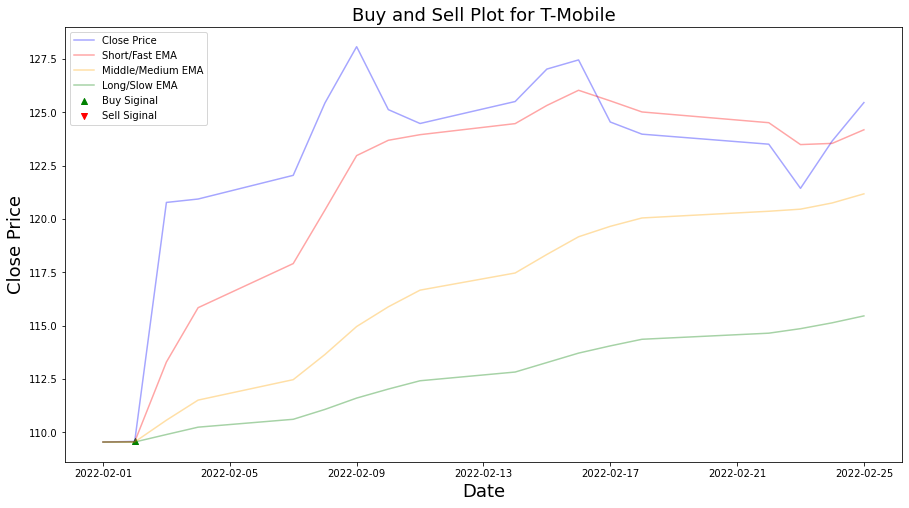

uploaded T-Mobile.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/T-Mobile.png
[*********************100%***********************]  1 of 1 completed


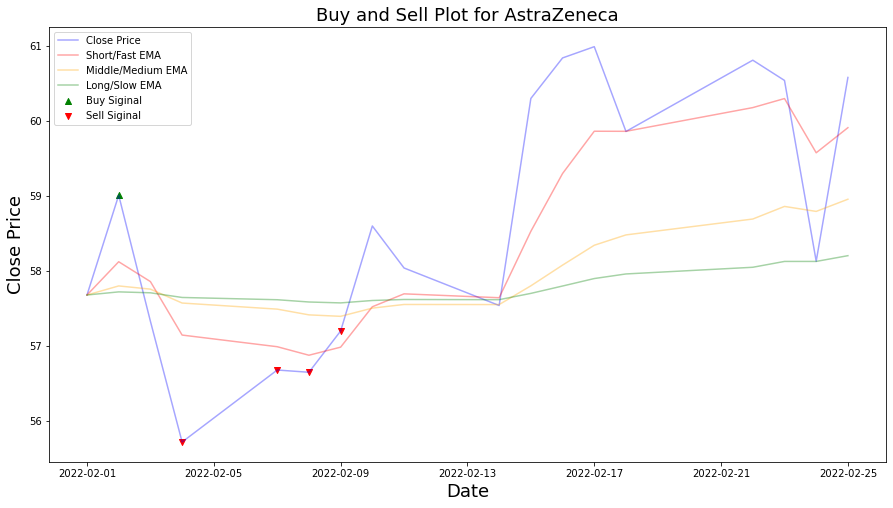

uploaded AstraZeneca.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/AstraZeneca.png
[*********************100%***********************]  1 of 1 completed


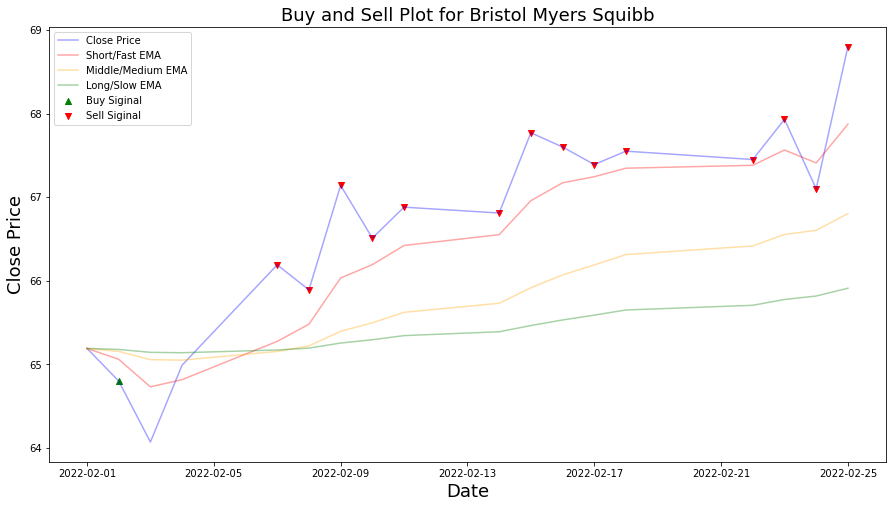

uploaded Bristol Myers Squibb.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Bristol Myers Squibb.png
[*********************100%***********************]  1 of 1 completed


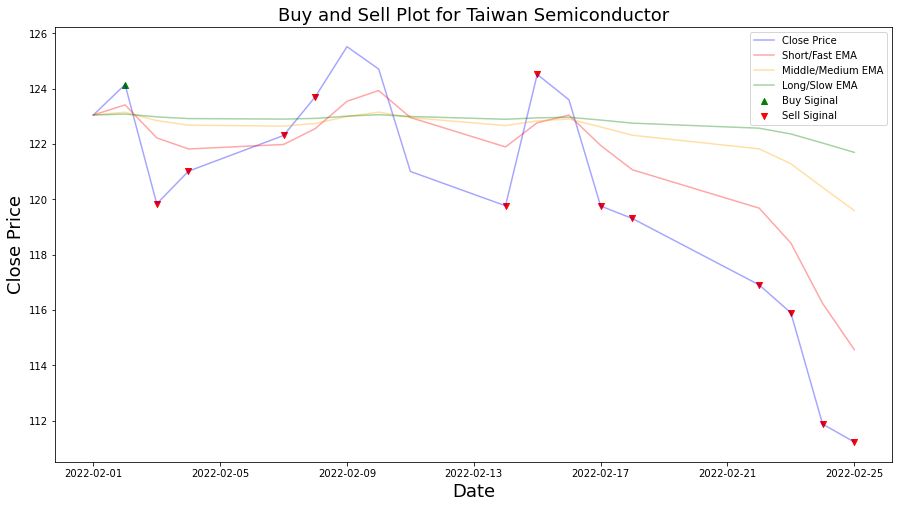

uploaded Taiwan Semiconductor.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Taiwan Semiconductor.png
[*********************100%***********************]  1 of 1 completed


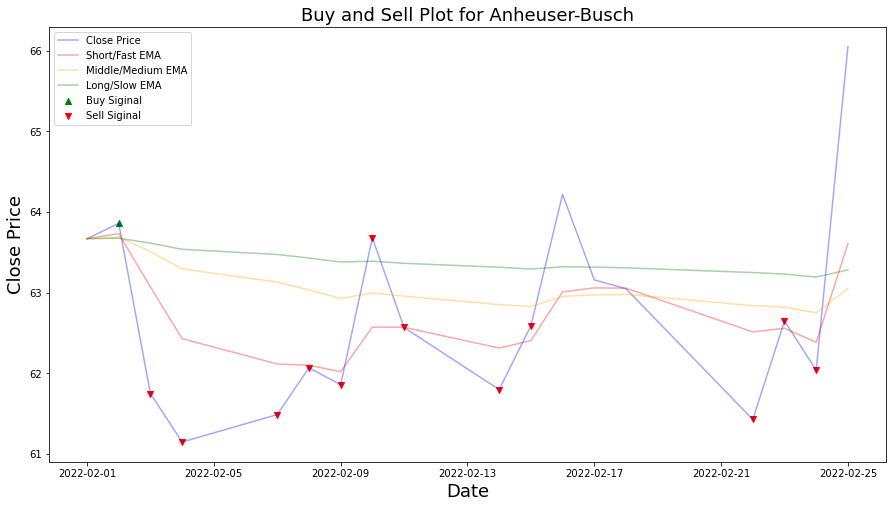

uploaded Anheuser-Busch.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Anheuser-Busch.png
[*********************100%***********************]  1 of 1 completed


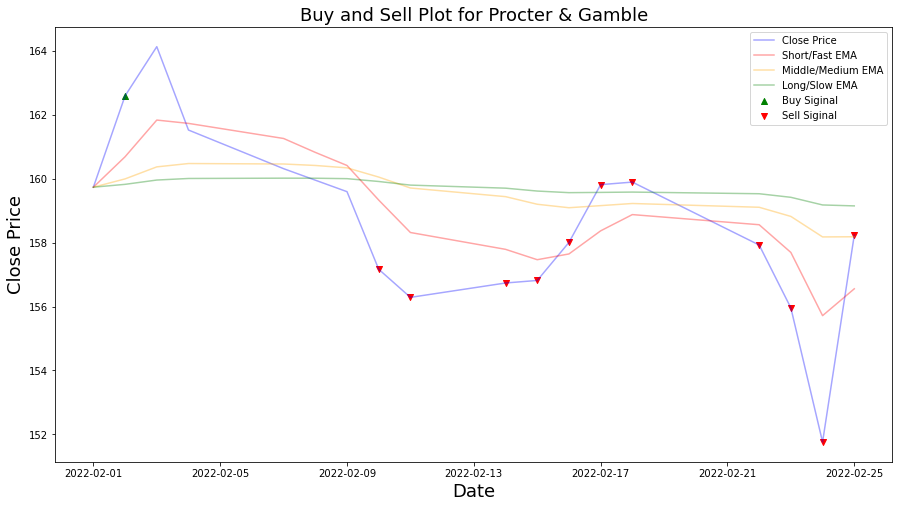

uploaded Procter & Gamble.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Procter & Gamble.png
[*********************100%***********************]  1 of 1 completed


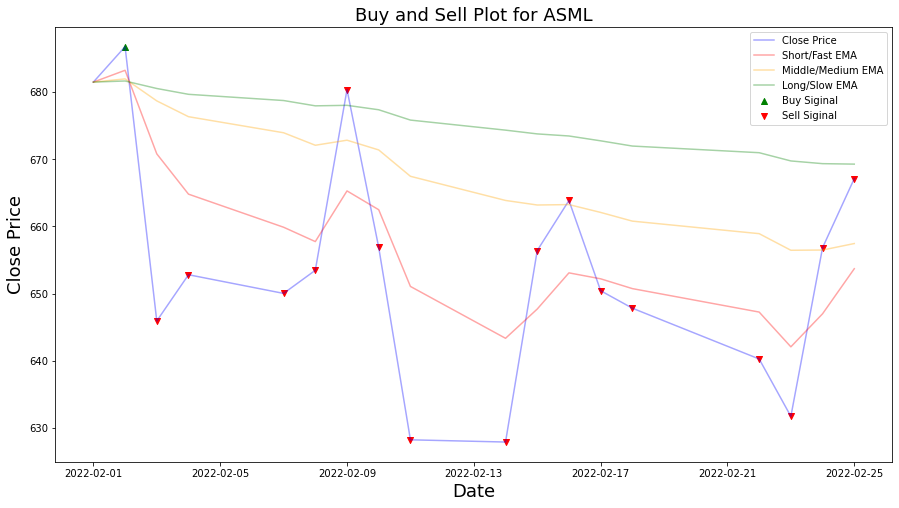

uploaded ASML.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/ASML.png
[*********************100%***********************]  1 of 1 completed


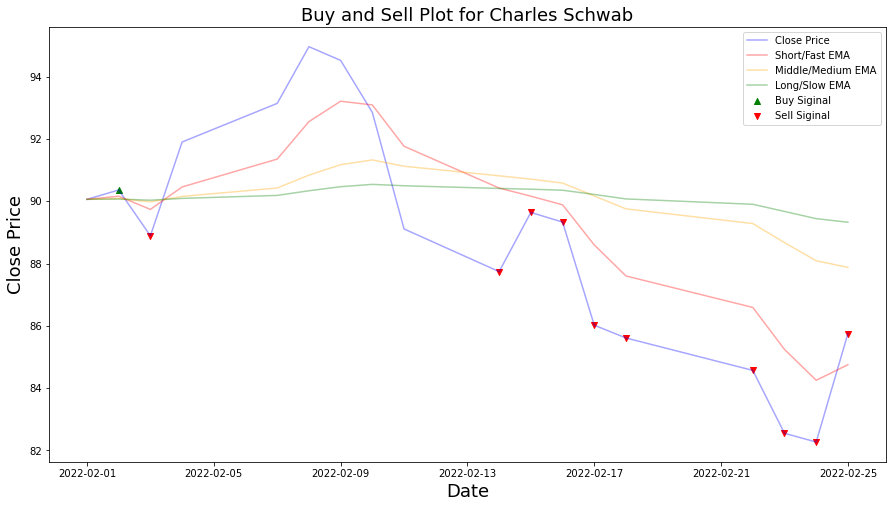

uploaded Charles Schwab.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Charles Schwab.png
[*********************100%***********************]  1 of 1 completed


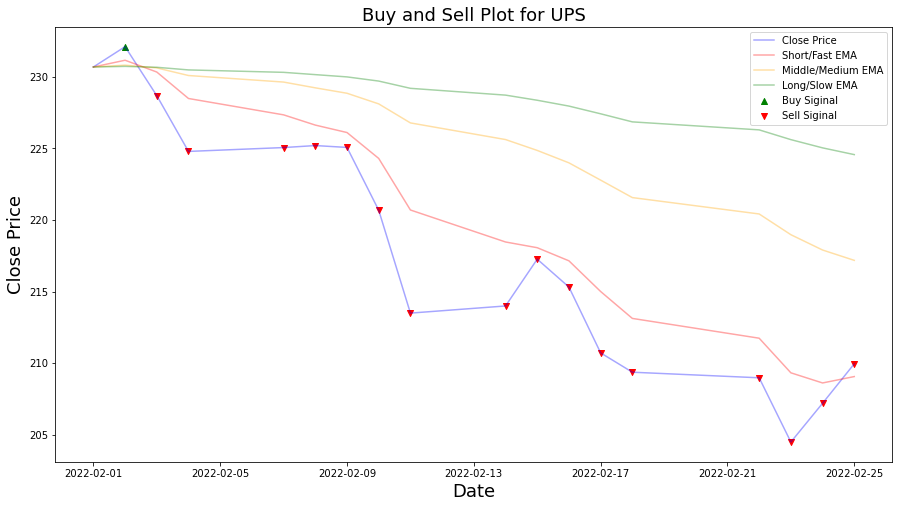

uploaded UPS.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/UPS.png
[*********************100%***********************]  1 of 1 completed


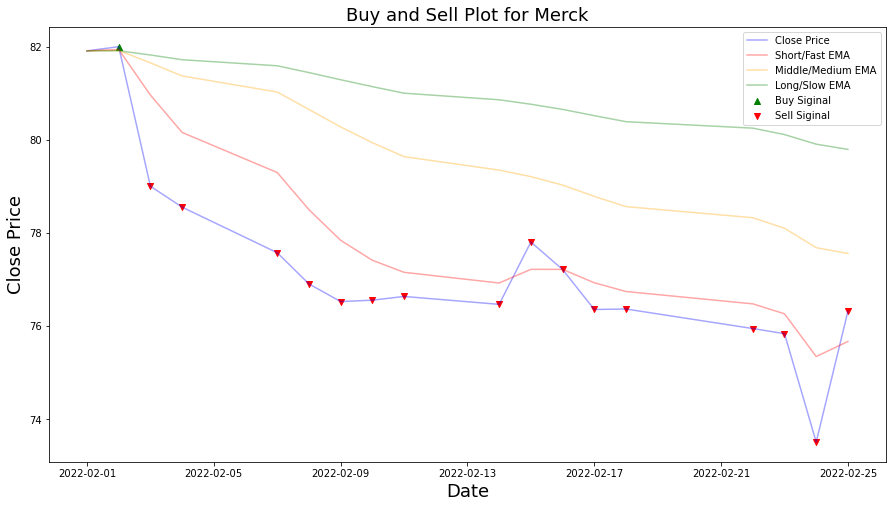

uploaded Merck.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Merck.png
[*********************100%***********************]  1 of 1 completed


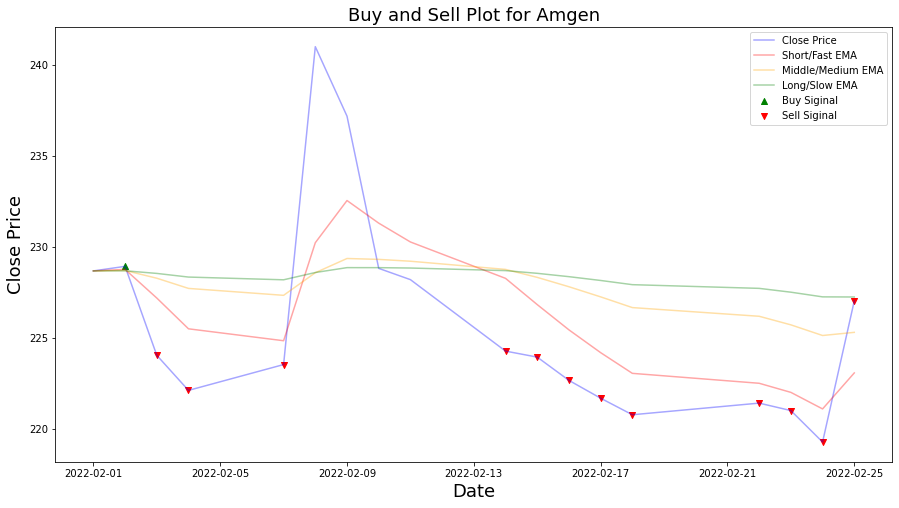

uploaded Amgen.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Amgen.png
[*********************100%***********************]  1 of 1 completed


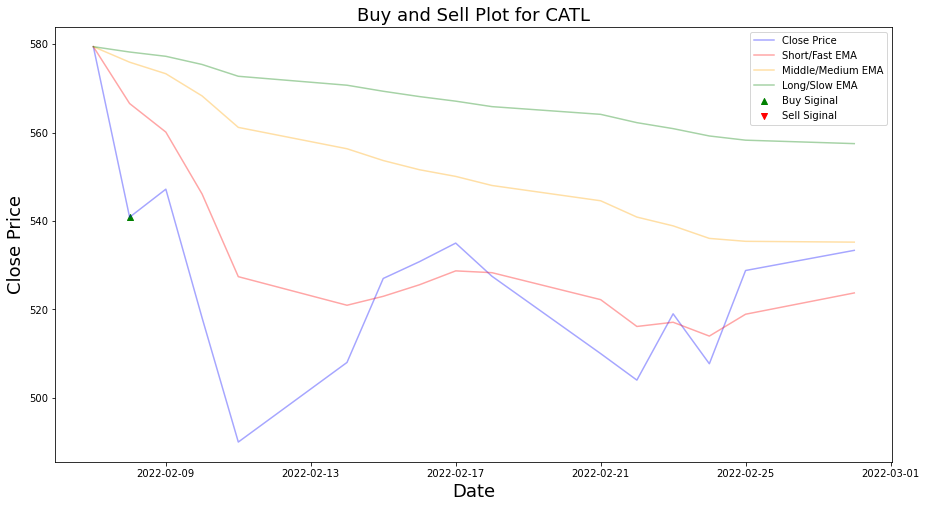

uploaded CATL.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/CATL.png
[*********************100%***********************]  1 of 1 completed


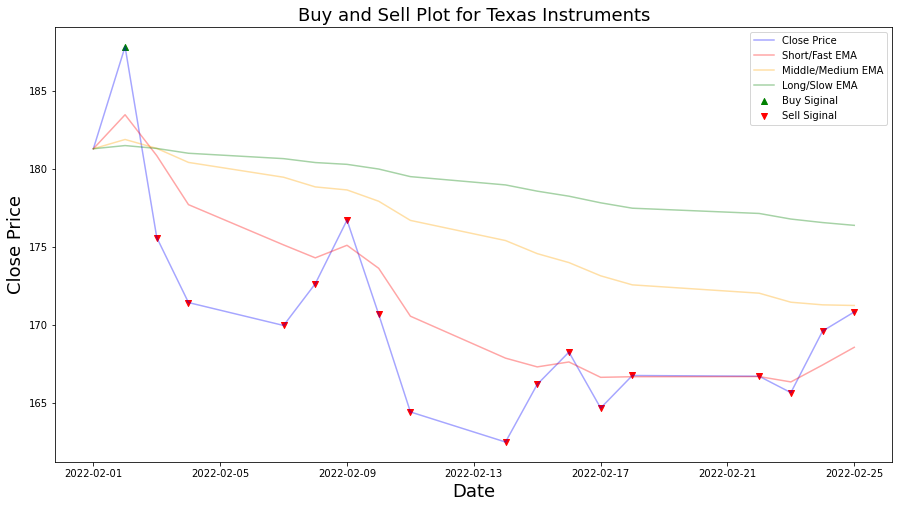

uploaded Texas Instruments.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Texas Instruments.png
[*********************100%***********************]  1 of 1 completed


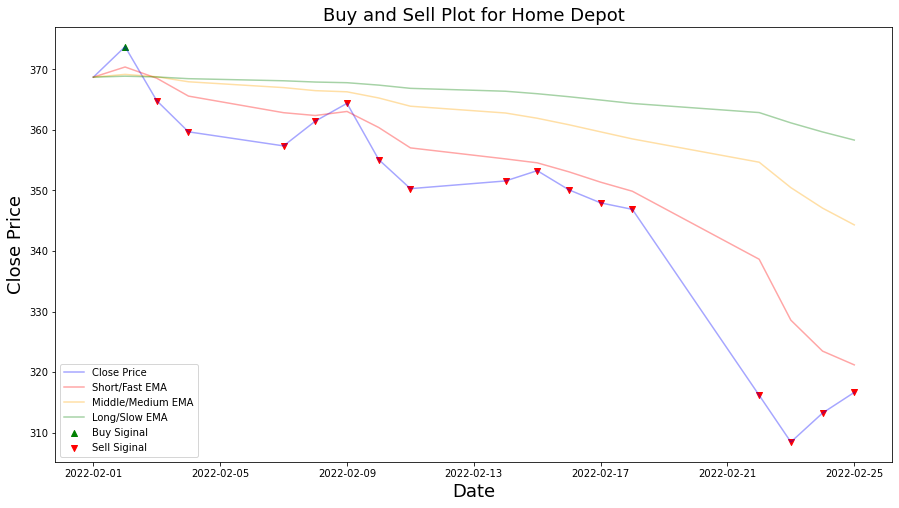

uploaded Home Depot.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/4_neutral/Home Depot.png


In [12]:
moving_avarage_analysis(neutral_list, 4)

[*********************100%***********************]  1 of 1 completed


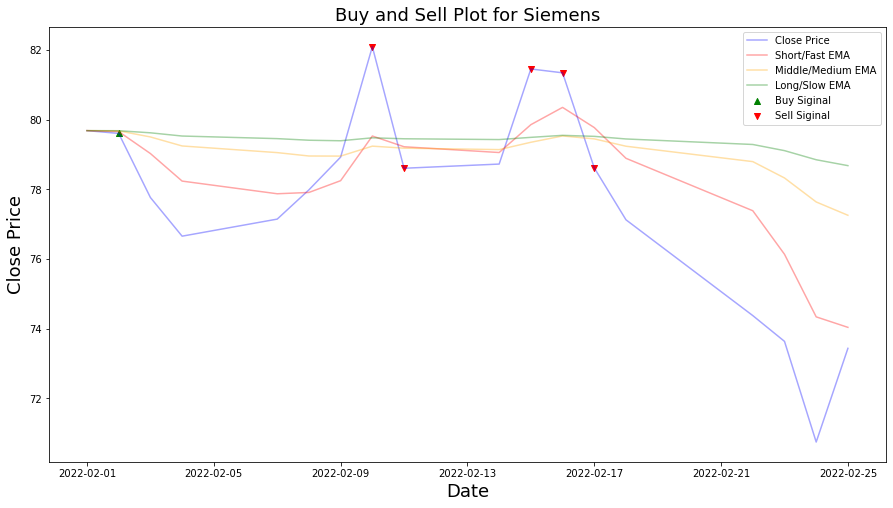

uploaded Siemens.png to Firebase in: Predictions/2022_Feb_Predictions/graphs/3_moving_average_analysis/5_weak_negative/Siemens.png


In [13]:
moving_avarage_analysis(wnegative_list, 5)

In [14]:
moving_avarage_analysis(negative_list, 6)

In [15]:
moving_avarage_analysis(snegative_list, 7)